**MScFE 642: Deep Learning for Finance**

**Deep Learning for Finance**

**GWP 2**

**Student Group 6905**

The group wants to produce a **Deep Learning** model that tries to predict short-term market trends across different asset classes. We will also test the
out-of-sample performance of different asset allocation strategies based on the
predictions of the model.

**Step 1**

**1(a) Data Import**

In [109]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
plt.rcParams["figure.figsize"] = (6.4,4.8)
plt.rcParams['figure.facecolor'] = 'white'
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')


In [110]:
# Define the ETF symbols
etfs = {
    'Equity': 'SPY',
    'Fixed Income': 'TLT',
    'Cash-like': 'SHY',
    'Precious metals': 'GLD',
    'Crude Oil': 'DBO'
}

# Download data for the specified period
start_date = '2018-01-01'
end_date = '2022-12-30'
data = yf.download(list(etfs.values()), start=start_date, end=end_date)['Adj Close']
data.head()

[*********************100%***********************]  5 of 5 completed


Ticker                          DBO         GLD        SHY         SPY  \
Date                                                                     
2018-01-02 00:00:00+00:00  9.376729  125.150002  74.655052  241.540115   
2018-01-03 00:00:00+00:00  9.579170  124.820000  74.655052  243.067932   
2018-01-04 00:00:00+00:00  9.597575  125.459999  74.619446  244.092392   
2018-01-05 00:00:00+00:00  9.551564  125.330002  74.619446  245.719101   
2018-01-08 00:00:00+00:00  9.606776  125.309998  74.619446  246.168365   

Ticker                            TLT  
Date                                   
2018-01-02 00:00:00+00:00  106.869896  
2018-01-03 00:00:00+00:00  107.380867  
2018-01-04 00:00:00+00:00  107.363792  
2018-01-05 00:00:00+00:00  107.057243  
2018-01-08 00:00:00+00:00  106.989128

Looking at the Summary Statistics

In [111]:
# Summary statistics for each ETF
summary_stats = data.describe()
print(summary_stats)

Ticker          DBO          GLD          SHY          SPY          TLT
count   1258.000000  1258.000000  1258.000000  1258.000000  1258.000000
mean      10.914440   150.921431    78.125786   324.525477   121.106339
std        3.192079    22.501465     2.265497    69.694945    17.246951
min        4.941839   111.099998    74.350868   209.257553    86.630600
25%        8.891168   125.865000    76.305683   260.664307   105.139776
50%       10.212859   159.434998    78.107471   306.312698   123.145111
75%       12.513782   169.345005    80.609324   389.519447   135.602058
max       20.033457   193.889999    80.759857   460.127319   155.073334


Visualizing the Prices

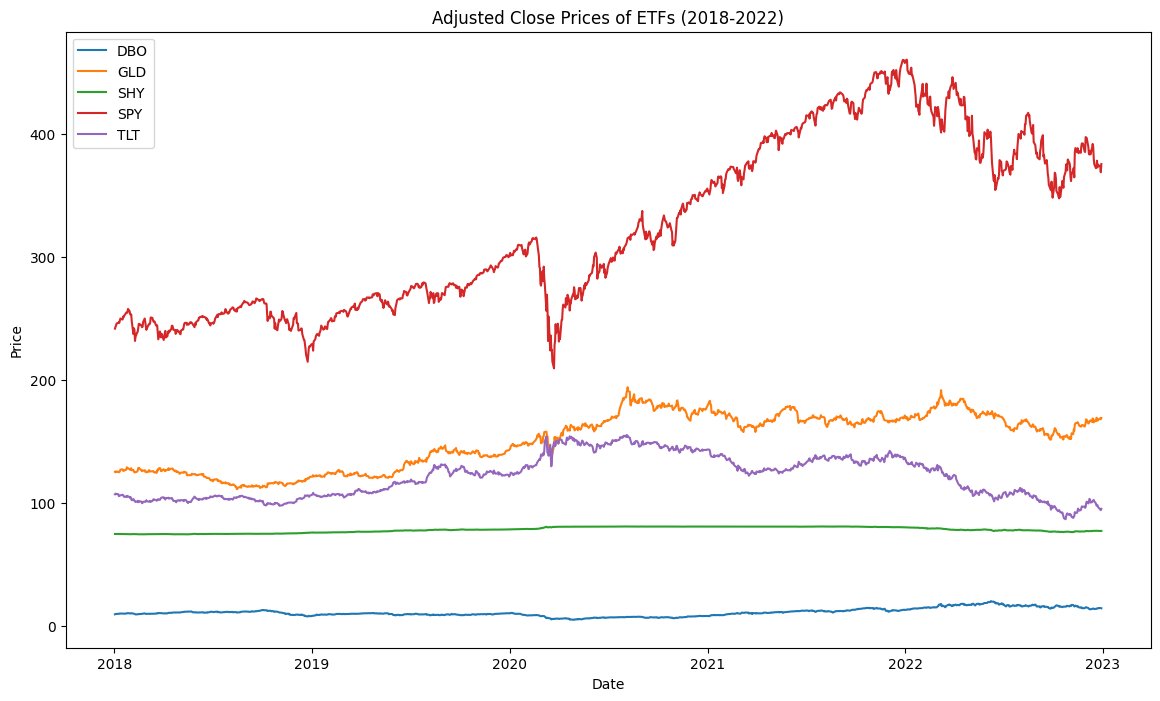

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the adjusted close prices over time
plt.figure(figsize=(14, 8))
for column in data.columns:
    plt.plot(data.index, data[column], label=column)

plt.title('Adjusted Close Prices of ETFs (2018-2022)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

**SPY (Equity - Red Line)**: The SPDR S&P 500 ETF, representing equities, shows a significant upward trend from 2018 to the end of 2022. There was a noticeable drop in early 2020, likely due to the COVID-19 pandemic, but the recovery was swift, with the ETF reaching new highs afterward.

**GLD (Precious Metals - Orange Line)**: The SPDR Gold Shares ETF shows a moderate upward trend, with a significant spike around mid-2020, which could be attributed to the uncertainty and economic conditions during the pandemic.

**TLT (Fixed Income - Purple Line)**: The iShares 20+ Year Treasury Bond ETF remained relatively stable until the start of 2020, when it saw a spike. However, it gradually declined in the latter part of the period, indicating fluctuations in long-term bond prices.

**SHY (Cash-like - Green Line)**: The iShares 1-3 Year Treasury Bond ETF has remained quite stable throughout the period, which is expected given its nature as a short-term bond fund.

**DBO (Crude Oil - Blue Line)**: The Invesco DB Oil Fund showed significant volatility, particularly during the 2020 oil price crash, but remained relatively low in price compared to the other ETFs.

Daily Returns and Visualization

Ticker          DBO          GLD          SHY          SPY          TLT
count   1257.000000  1257.000000  1257.000000  1257.000000  1257.000000
mean       0.000569     0.000279     0.000026     0.000443    -0.000041
std        0.021621     0.009047     0.000882     0.013580     0.010170
min       -0.166453    -0.053694    -0.005088    -0.109424    -0.066683
25%       -0.009609    -0.004327    -0.000347    -0.005132    -0.005782
50%        0.002437     0.000518     0.000000     0.000772     0.000072
75%        0.012708     0.005093     0.000354     0.007113     0.005657
max        0.106227     0.048530     0.005453     0.090603     0.075195


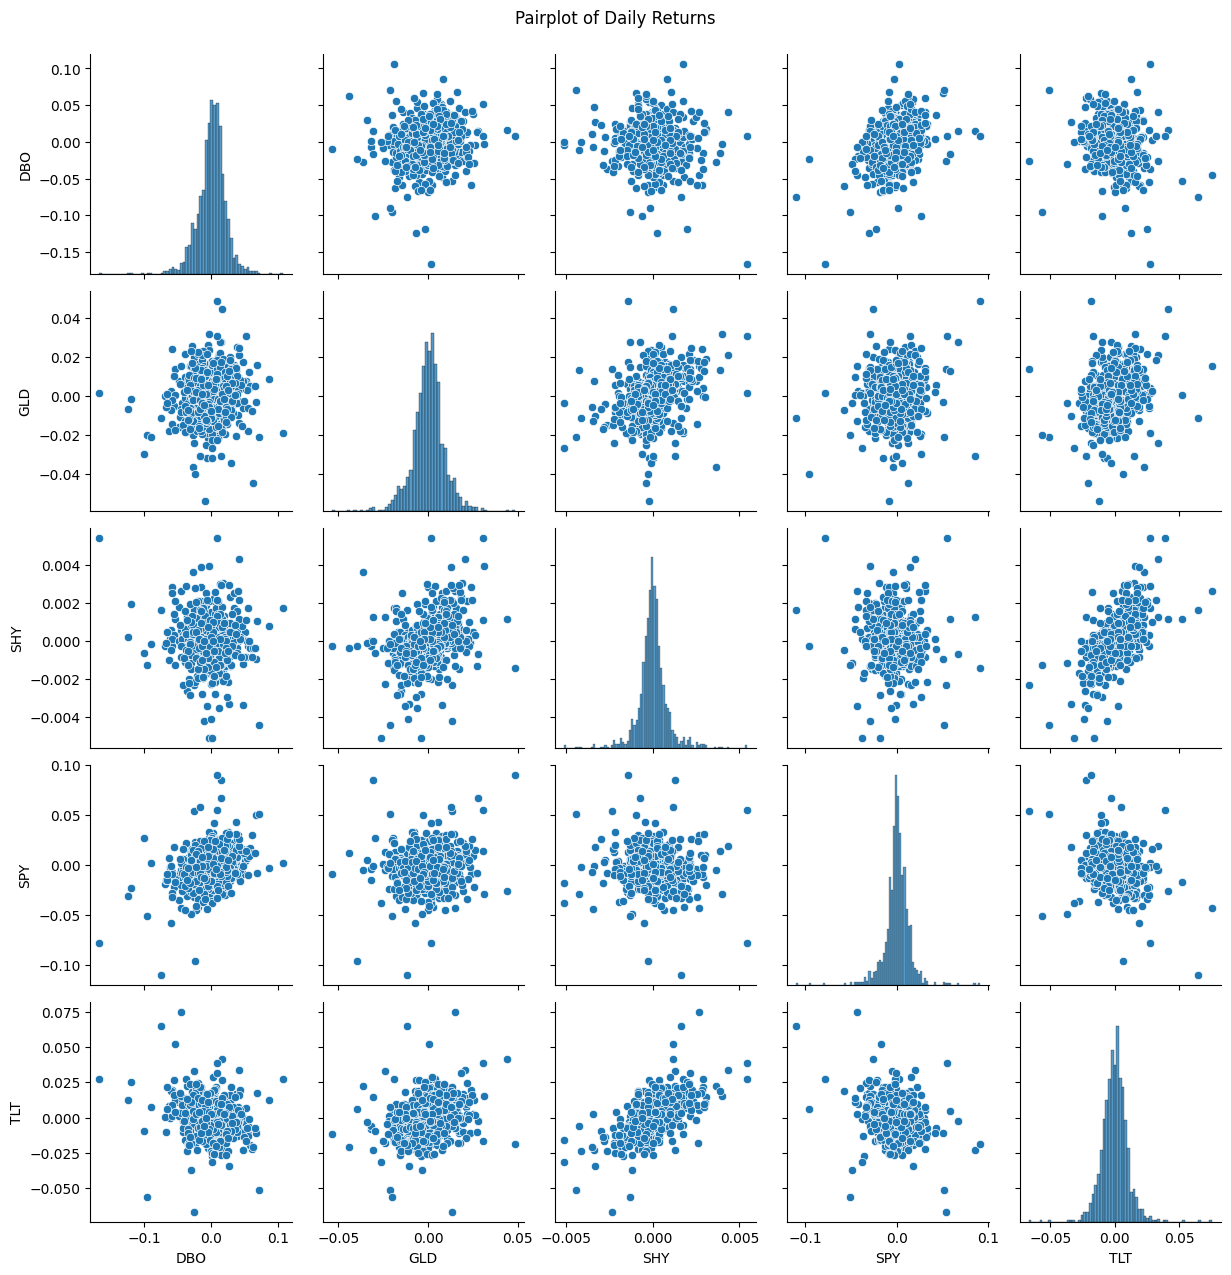

In [113]:
# Calculate daily returns
returns = data.pct_change().dropna()

# Summary statistics for returns
returns_stats = returns.describe()
print(returns_stats)

# Pairplot of daily returns
sns.pairplot(returns)
plt.suptitle('Pairplot of Daily Returns', y=1.02)
plt.show()


This plot shows the distributions of daily returns for each ETF and their relationships with one another. The diagonal plots (histograms) reveal the distribution of daily returns for each ETF.

**SPY:** The distribution of daily returns is centered around zero with some spread, indicating variability in daily returns but no significant skew.

**GLD, SHY, TLT:** These ETFs have a similar spread in daily returns but show different distributions, with some being more tightly clustered around zero (e.g., SHY).

**DBO:** The daily returns of DBO show more spread compared to the others, highlighting the volatility in crude oil prices.

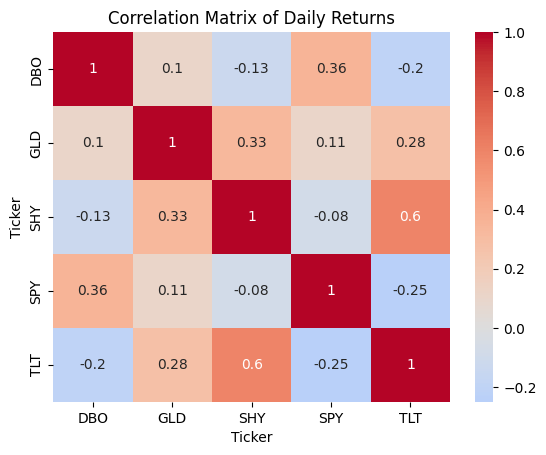

In [114]:
# Correlation matrix of daily returns
correlation_matrix = returns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Daily Returns')
plt.show()

The correlation matrix provides insight into how these ETFs move in relation to one another on a daily basis.

**High Positive Correlation:**

**SHY and TLT (0.6):** This is expected as both are related to bonds, with SHY representing short-term and TLT long-term bonds.

**SPY and DBO (0.36):** There is a moderate positive correlation, which might be due to economic factors affecting both equities and oil prices.

**Low or Negative Correlation:**

**SPY and TLT (-0.25):** There is a slight negative correlation between equities and long-term bonds, reflecting a typical risk-off and risk-on relationship.

**DBO and TLT (-0.2):** Oil prices (DBO) and long-term bonds (TLT) also show a negative correlation, possibly due to different market forces driving these asset classes.

Stationarity Test

In [115]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'ADF Statistic for {title}: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Perform ADF test on each ETF's daily returns
for column in returns.columns:
    adf_test(returns[column], title=column)

ADF Statistic for DBO: -37.00602768070007
p-value: 0.0
Critical Values:
	1%: -3.4355671297788666
	5%: -2.8638438984080117
	10%: -2.5679966213893057
ADF Statistic for GLD: -15.40761040917371
p-value: 3.1543671248637953e-28
Critical Values:
	1%: -3.435592223709696
	5%: -2.8638549702604803
	10%: -2.56800251776
ADF Statistic for SHY: -6.671571149615736
p-value: 4.573816866839242e-09
Critical Values:
	1%: -3.435638861796935
	5%: -2.863875547501718
	10%: -2.5680134763122906
ADF Statistic for SPY: -10.94711549726806
p-value: 8.988770698555885e-20
Critical Values:
	1%: -3.4356006420838963
	5%: -2.8638586845641063
	10%: -2.5680044958343604
ADF Statistic for TLT: -10.545112230669885
p-value: 8.452580879759428e-19
Critical Values:
	1%: -3.4356048614183443
	5%: -2.8638605461891617
	10%: -2.5680054872544145


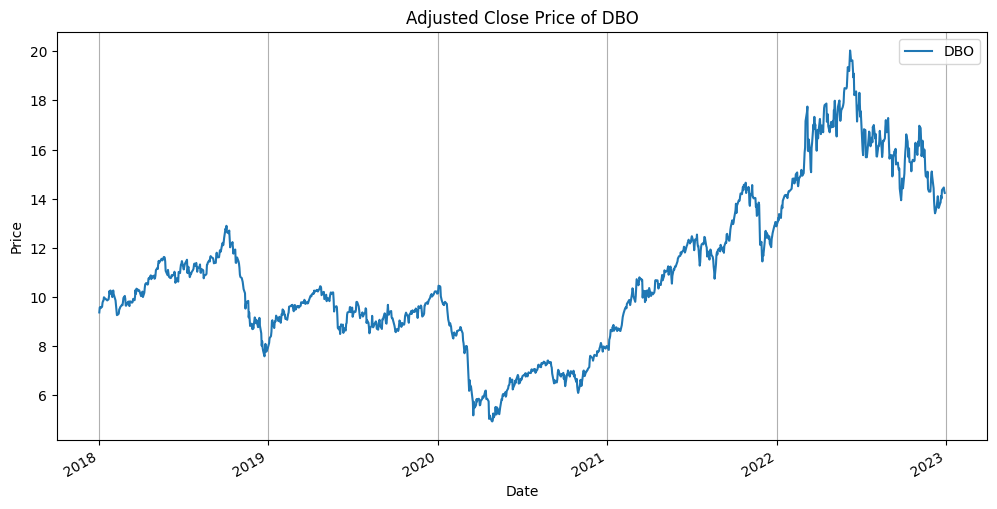

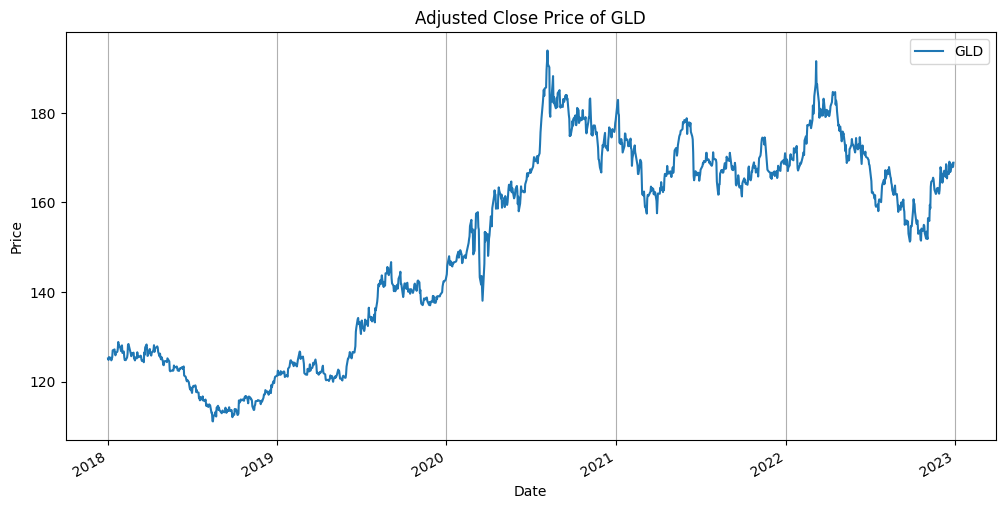

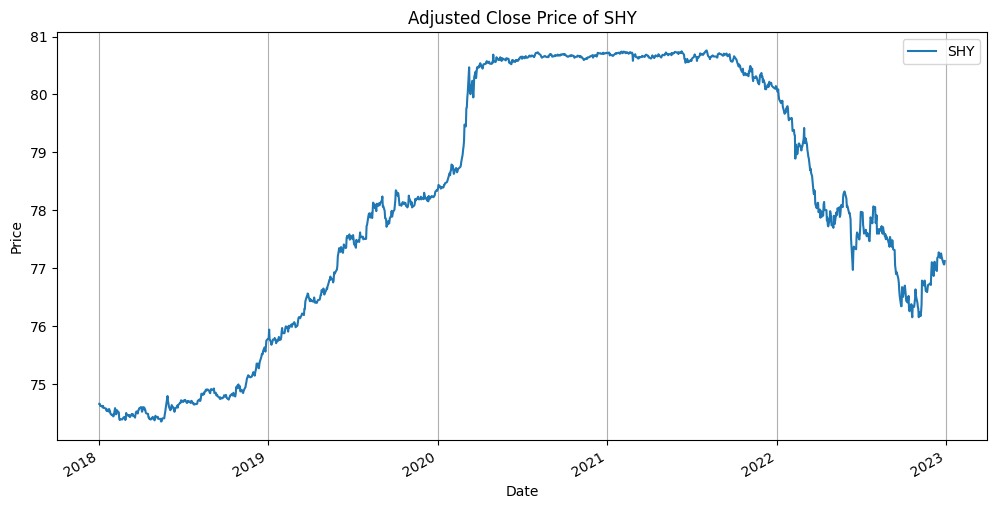

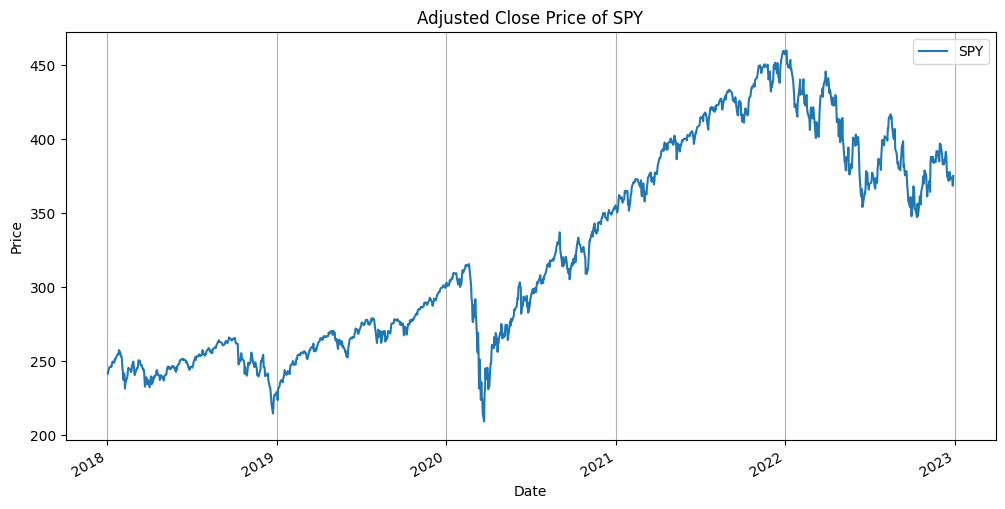

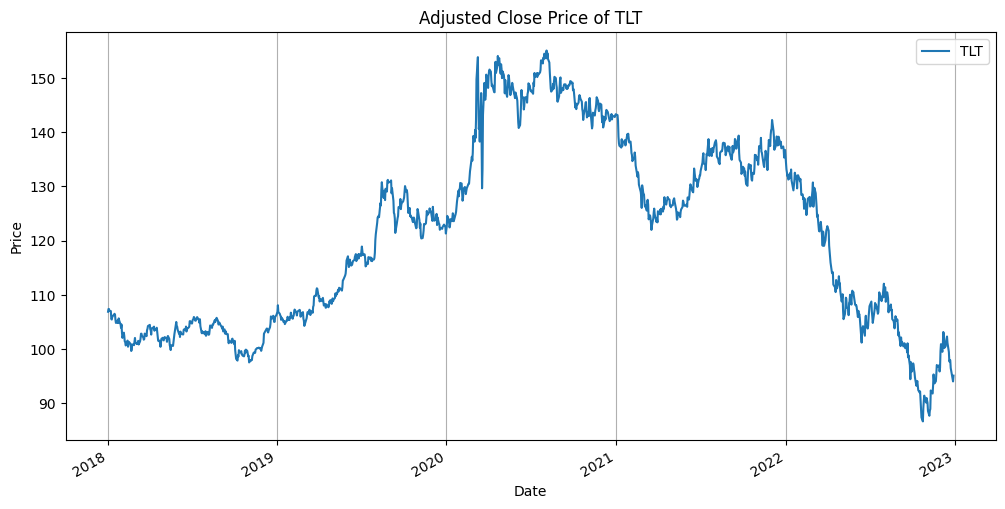

In [116]:
# Assuming 'data' already contains adjusted close prices
for column in data.columns:
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    data.plot(y=column, label=column, ax=ax).grid(axis="x")
    plt.title(f'Adjusted Close Price of {column}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()


**1. SPY (Equity - S&P 500)**

**Trend:** The SPY ETF shows a significant upward trend from 2018 to early 2022, followed by a sharp decline in 2022. The price peaked around the end of 2021 and has since been volatile.

**Volatility:** There is evident volatility, particularly during the 2020 COVID-19 pandemic when the market experienced a sharp drop, followed by a strong recovery.

**Market Regimes:** The chart shows different market regimes, with a bullish phase until 2021, followed by a bearish trend starting in 2022.

**2. TLT (Fixed Income - Long-term Treasury Bonds)**

**Trend:** TLT shows an increase in price until mid-2020, likely driven by falling interest rates and increased demand for safe-haven assets during the pandemic. Afterward, there is a consistent decline, particularly during 2021 and 2022, coinciding with rising interest rates.

**Volatility:** The volatility is less pronounced compared to SPY but increases during the market stress periods, especially in early 2020.

**Inverse Correlation:** Historically, TLT often moves inversely to equity markets, as observed during periods of equity market stress.

**3. SHY (Cash-like - Short-term Treasury Bonds)**

**Trend:** SHY exhibits a more stable price movement with much less volatility compared to SPY and TLT. The price shows a slight upward trend from 2018 to 2021 and a mild decline afterward.

**Volatility:** Very low volatility, which is typical for short-term bonds. The movements are much more muted, reflecting the lower risk associated with this asset class.


**4. DBO (Crude Oil - Invesco DB Oil Fund)**

**Trend:** The DBO ETF shows significant fluctuations from 2018 to early 2023. The price peaked in mid-2022 and experienced sharp declines, especially during early 2020, due to the COVID-19 pandemic and the subsequent collapse in oil demand.

**Volatility:** DBO is highly volatile, reflecting the commodity's sensitivity to global economic conditions, geopolitical events, and supply-demand changes. The volatility was particularly pronounced during the pandemic when prices dropped dramatically.

**Market Regimes:** The chart illustrates different market regimes, with sharp declines during the 2020 oil price crash, followed by recovery and growth until mid-2022, then another decline as market conditions fluctuated.

**5. GLD (Precious Metals - Gold)**

**Trend:** The GLD ETF generally trends upward from 2018 through mid-2020, peaking during the height of the pandemic when economic uncertainty was high. After 2021, the price shows some fluctuations with a slight downward trend until early 2023.

**Volatility:** GLD exhibits moderate volatility, especially during periods of market stress like the 2020 pandemic, when gold is often seen as a safe haven. However, the volatility is less compared to more cyclical assets like DBO.

**Safe Haven:** The chart reflects gold’s role as a safe-haven asset, with price increases during periods of economic uncertainty and relative stability compared to more volatile assets like crude oil.

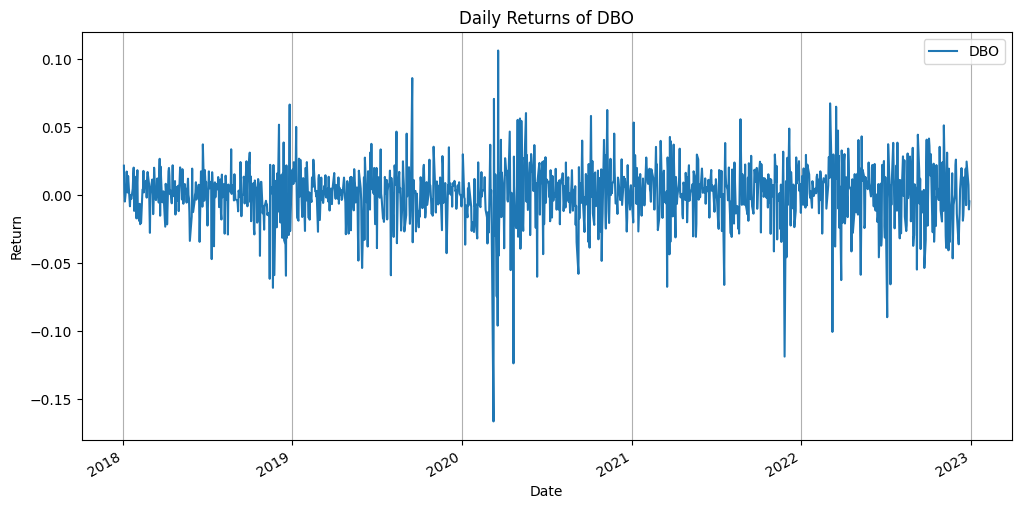

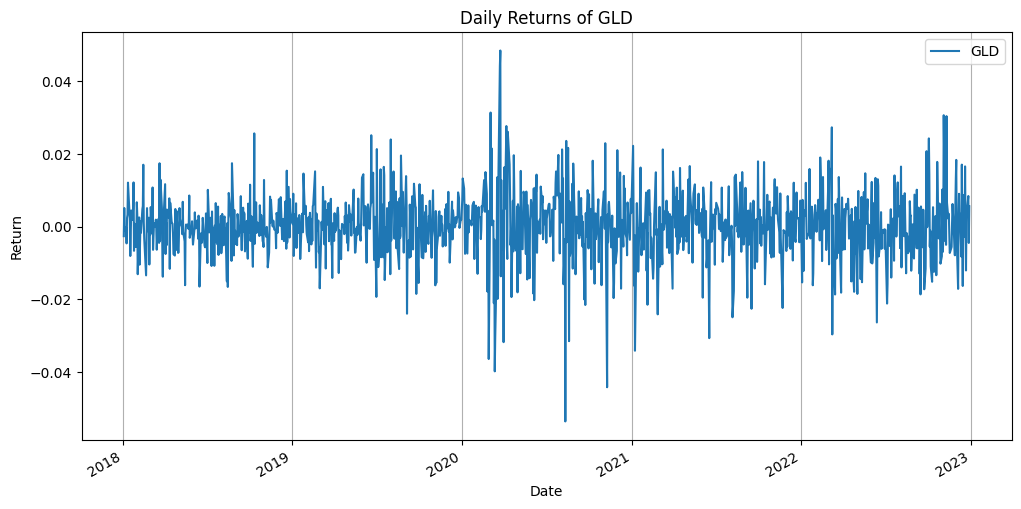

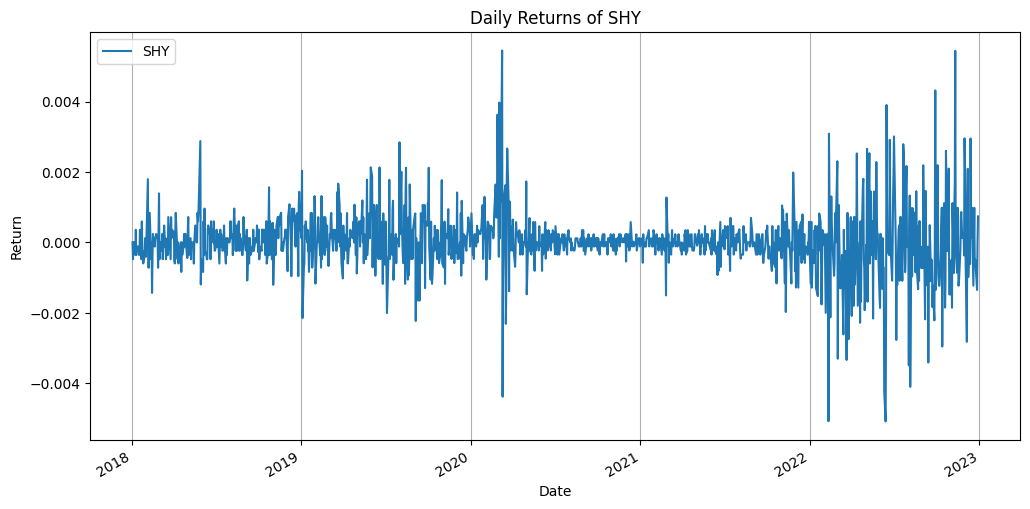

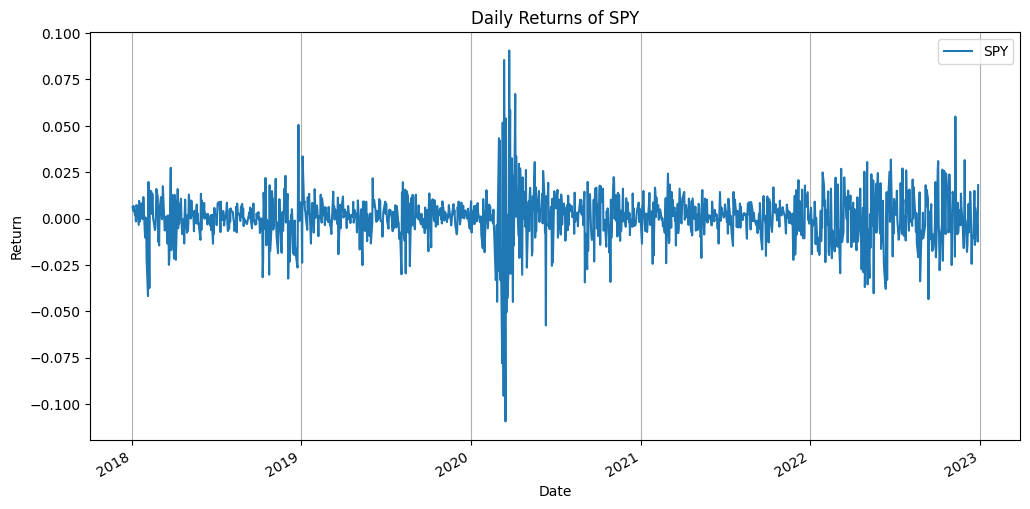

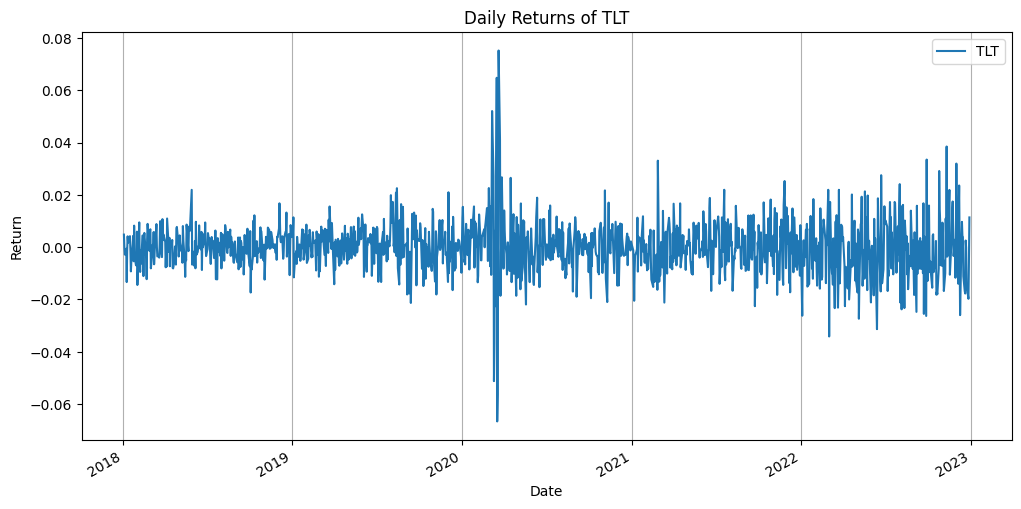

In [117]:
for column in returns.columns:
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    returns.plot(y=column, label=column, ax=ax).grid(axis="x")
    plt.title(f'Daily Returns of {column}')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.show()


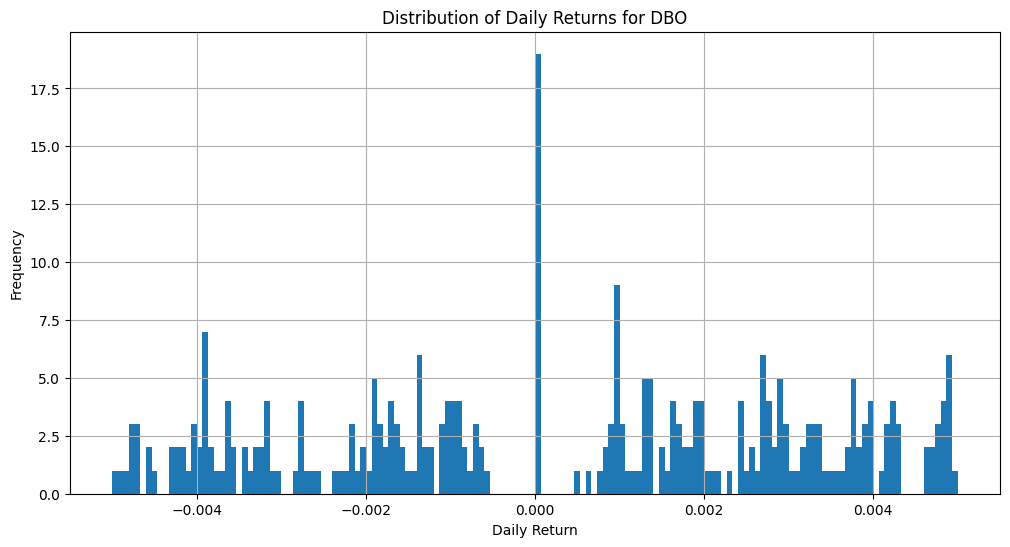

count    1257.000000
mean        0.000569
std         0.021621
min        -0.166453
25%        -0.009609
50%         0.002437
75%         0.012708
max         0.106227
Name: DBO, dtype: float64


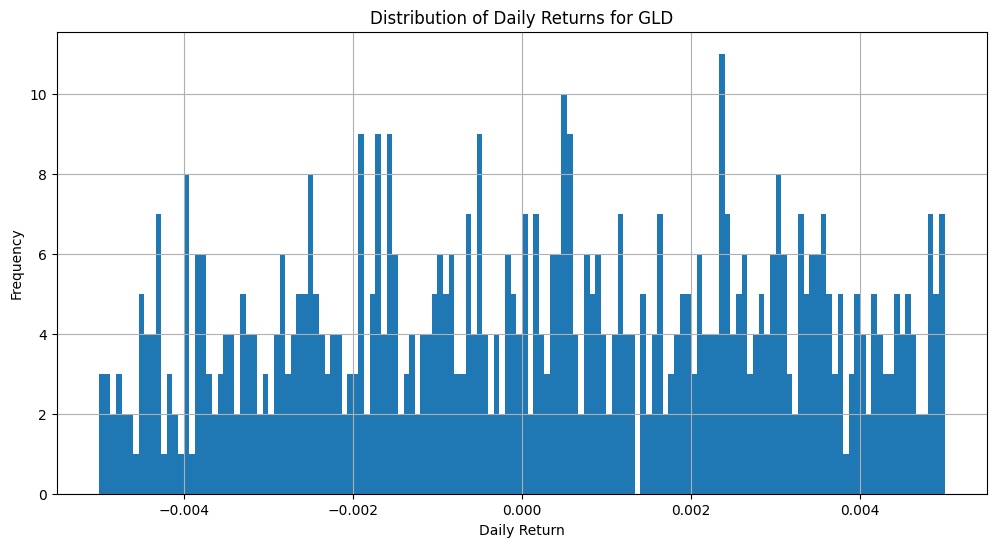

count    1257.000000
mean        0.000279
std         0.009047
min        -0.053694
25%        -0.004327
50%         0.000518
75%         0.005093
max         0.048530
Name: GLD, dtype: float64


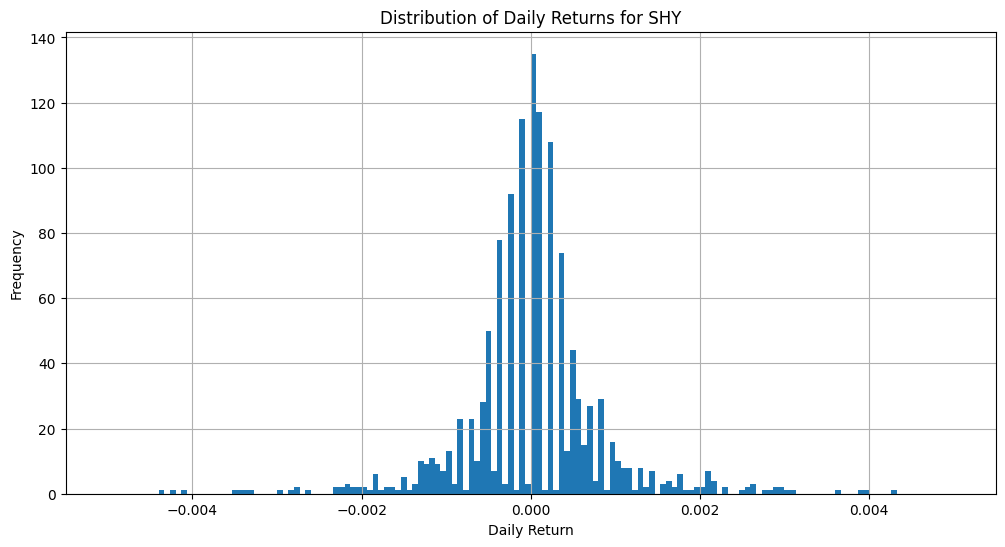

count    1257.000000
mean        0.000026
std         0.000882
min        -0.005088
25%        -0.000347
50%         0.000000
75%         0.000354
max         0.005453
Name: SHY, dtype: float64


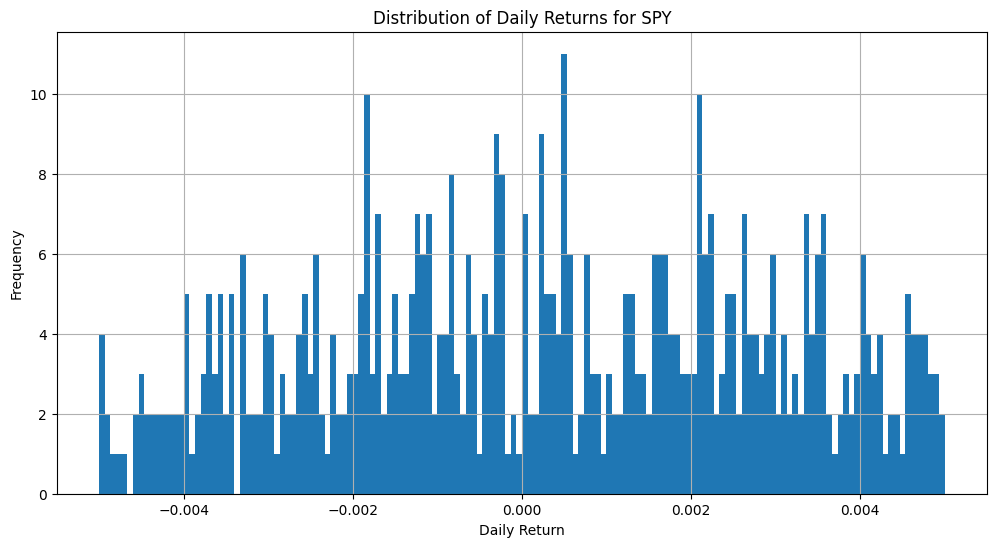

count    1257.000000
mean        0.000443
std         0.013580
min        -0.109424
25%        -0.005132
50%         0.000772
75%         0.007113
max         0.090603
Name: SPY, dtype: float64


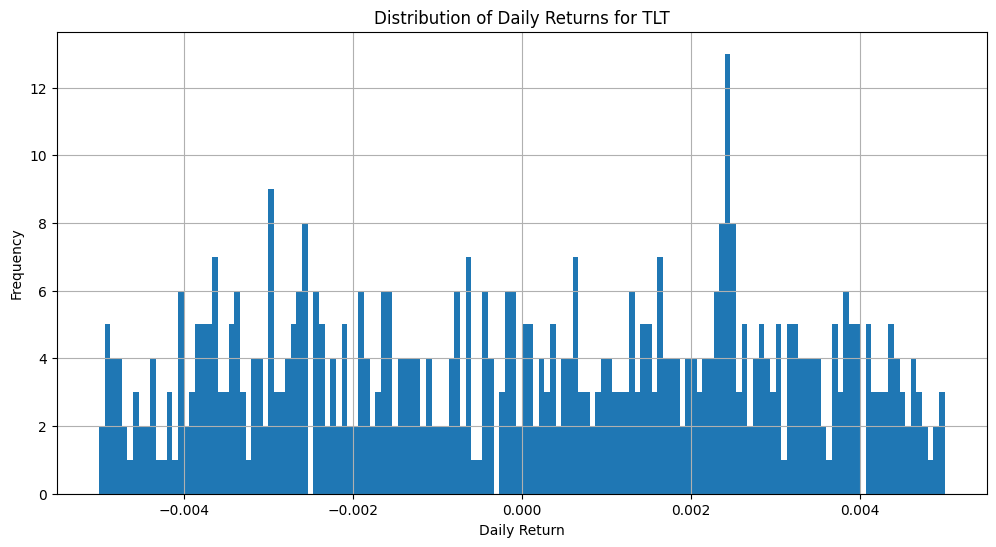

count    1257.000000
mean       -0.000041
std         0.010170
min        -0.066683
25%        -0.005782
50%         0.000072
75%         0.005657
max         0.075195
Name: TLT, dtype: float64


In [118]:
for column in returns.columns:
    fig = plt.figure(figsize=(12, 6))
    returns[column].hist(bins=150, range=[-0.005, 0.005])
    plt.title(f'Distribution of Daily Returns for {column}')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.show()

    print(returns[column].describe())


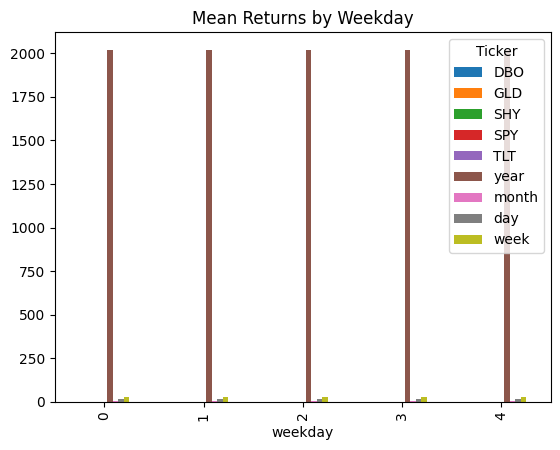

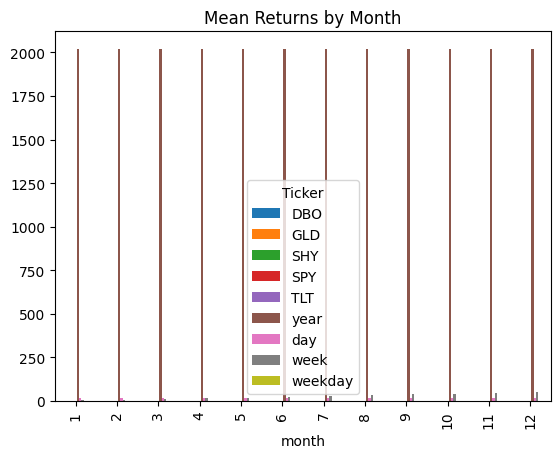

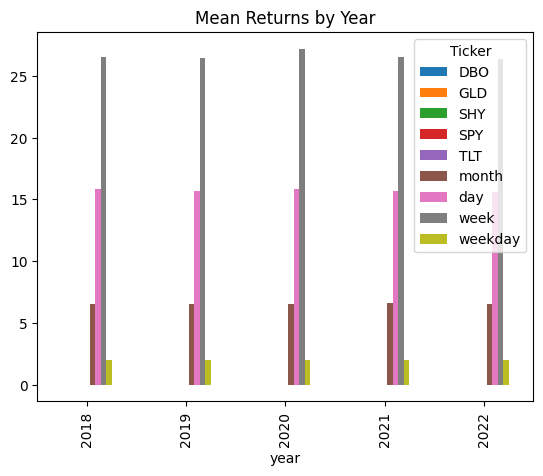

In [119]:
# Add date-based features
returns['year'] = returns.index.year
returns['month'] = returns.index.month
returns['day'] = returns.index.day
returns['week'] = returns.index.isocalendar().week
returns['weekday'] = returns.index.weekday


# Mean return by weekday
df_weekday = returns.groupby('weekday').mean()
df_weekday.plot(kind='bar')
plt.title('Mean Returns by Weekday')
plt.show()

# Mean return by month
df_month = returns.groupby('month').mean()
df_month.plot(kind='bar')
plt.title('Mean Returns by Month')
plt.show()

# Mean return by year
df_year = returns.groupby('year').mean()
df_year.plot(kind='bar')
plt.title('Mean Returns by Year')
plt.show()


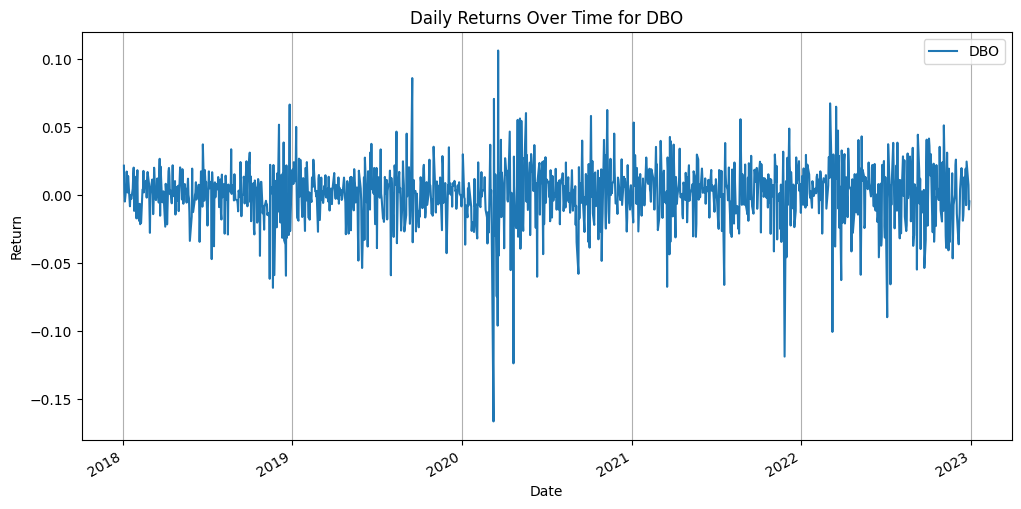

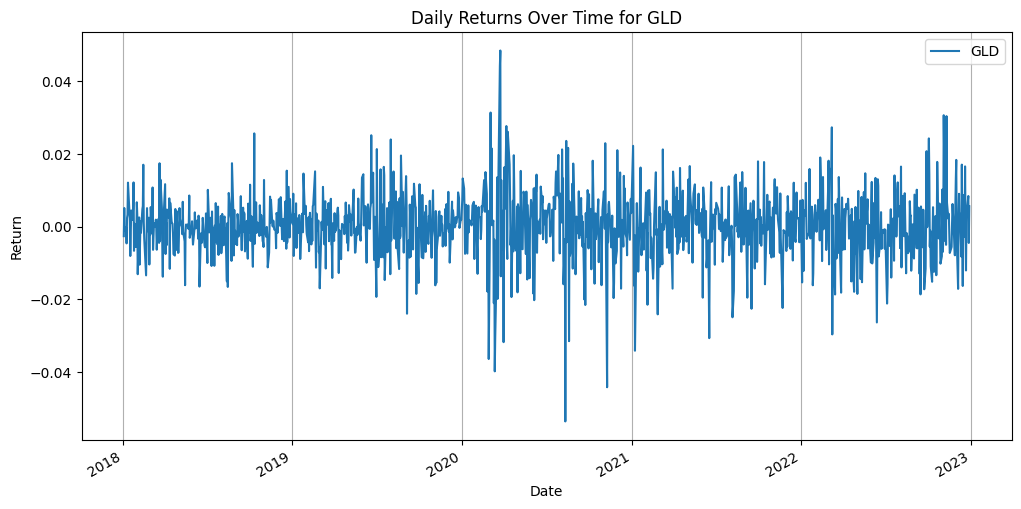

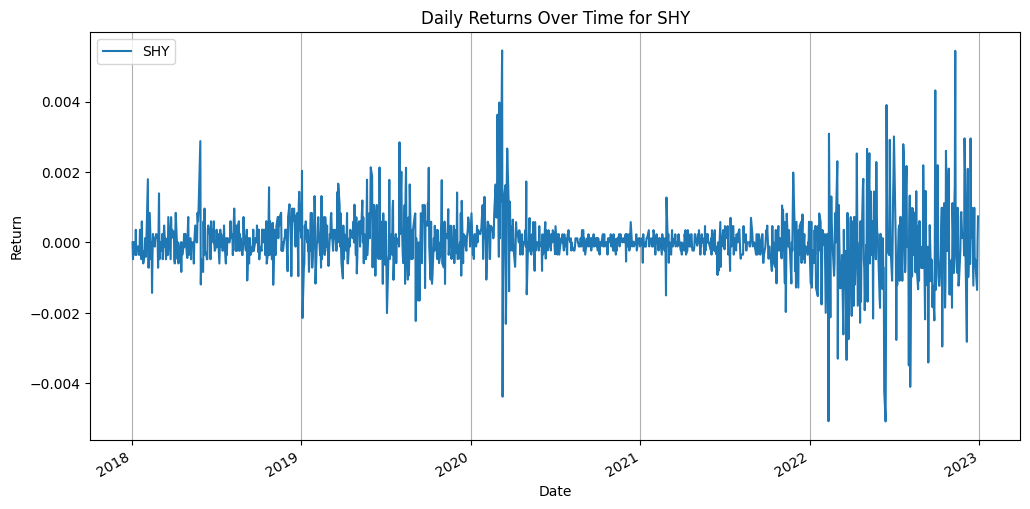

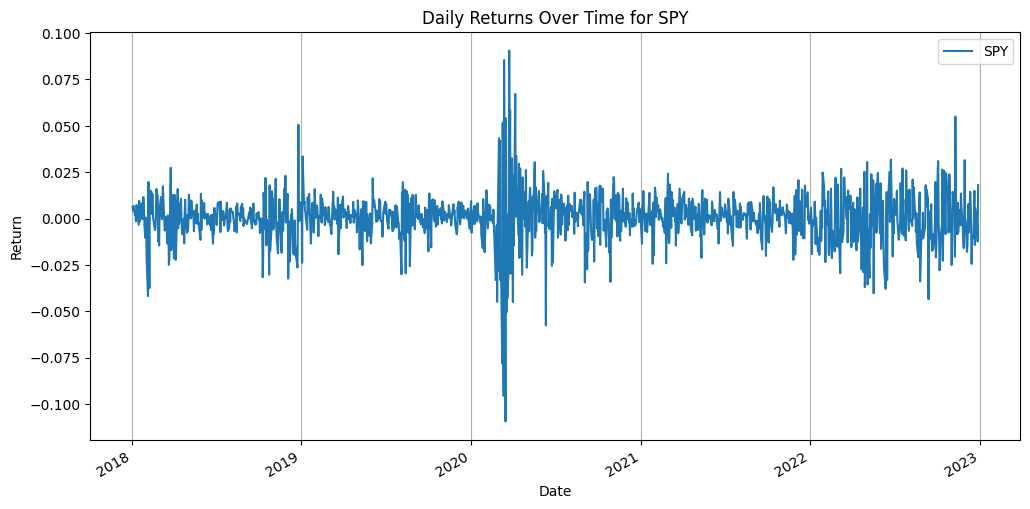

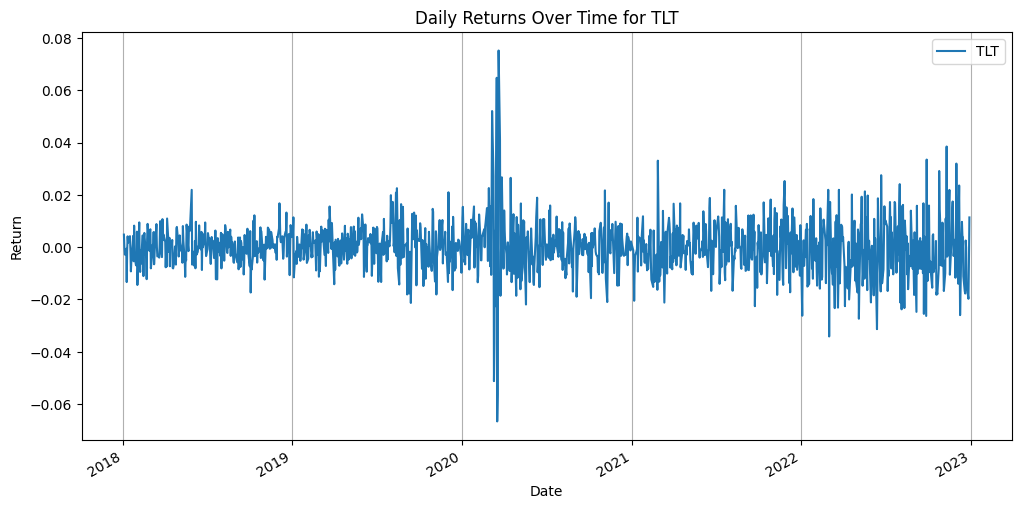

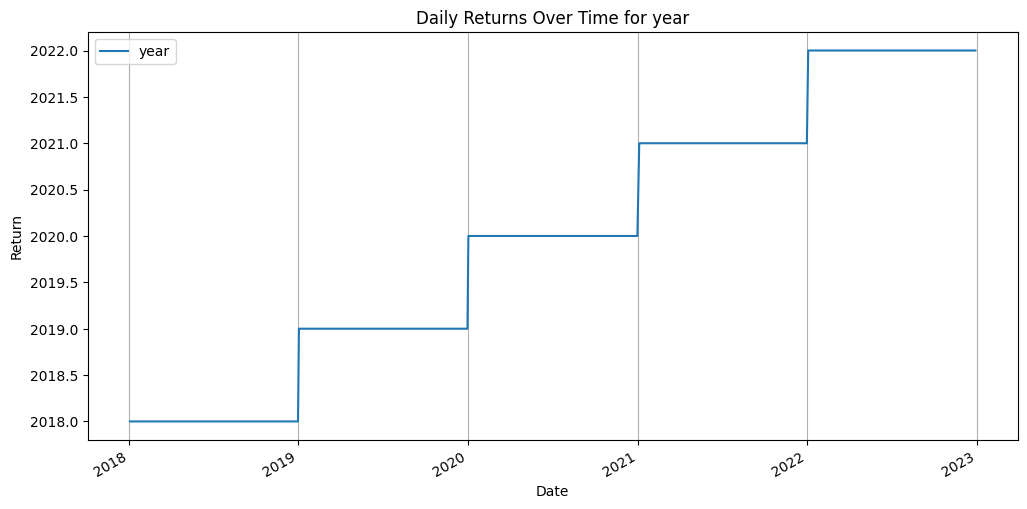

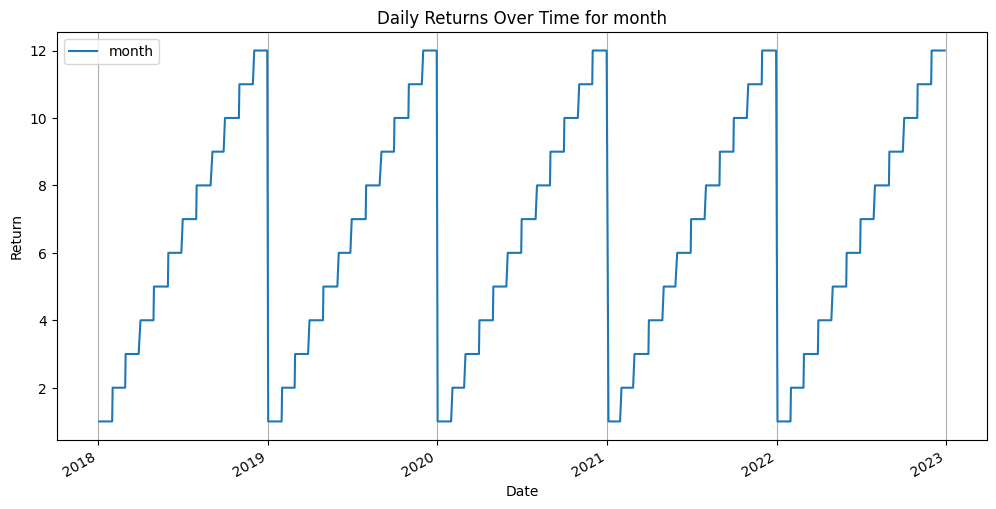

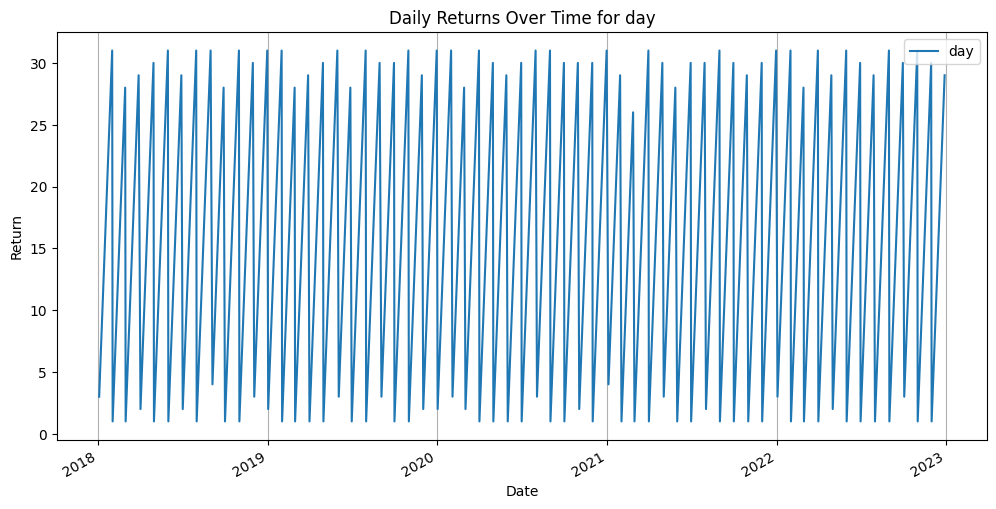

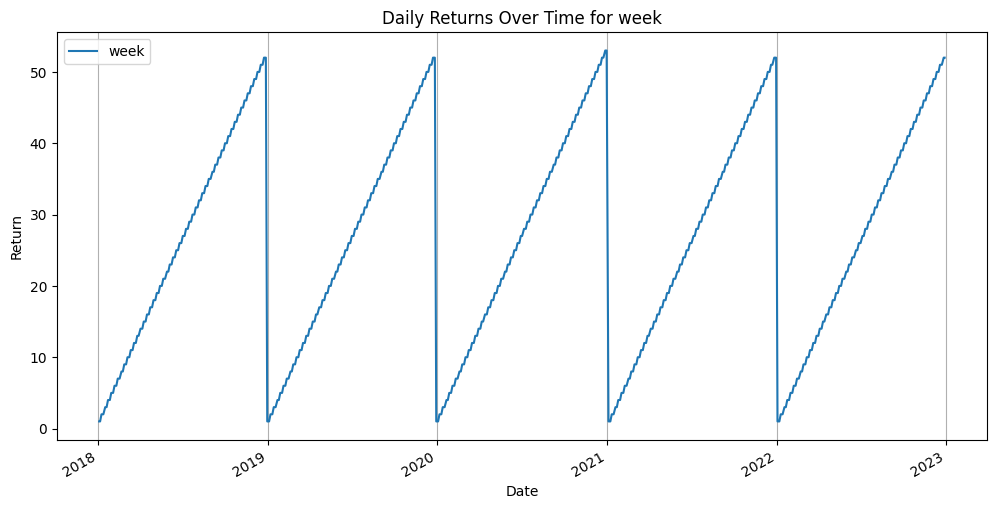

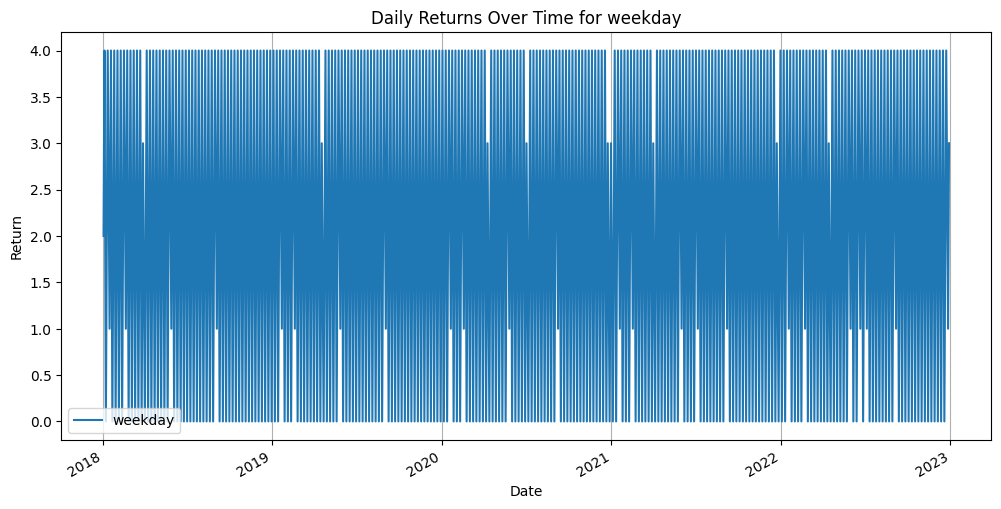

In [120]:
for column in returns.columns:
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    returns.plot(y=column, label=column, ax=ax).grid(axis="x")
    plt.title(f'Daily Returns Over Time for {column}')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.show()


# **In Step 2, you will create a Deep Learning model using recurrent neural networks to predict the 25-day ahead return of each of the 5 different asset classes.**

## **a. For each of the 5 different asset classes, create a Deep Learning model that uses LSTM network architecture (you may combine LSTM layers with regular dense layers) to predict the 25-day ahead return of each ETF. Use as inputs the past information of the time series (feel free to include whatever lags in returns you consider appropriate). You are free to select the model architecture you like. You can even play around with different architectures and choose the one that performs better.**

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping



In [49]:
# Step 1: Download data using yfinance
etf_symbols = ["SPY", "TLT", "SHY", "GLD", "DBO"]
start_date = "2018-01-01"
end_date = "2022-12-30"

# Step 2: Preprocessing the data
data = {}
for symbol in etf_symbols:
    etf_data = yf.download(symbol, start=start_date, end=end_date, interval="1d")
    df = pd.DataFrame(etf_data)
    df["Volume"] = df["Volume"].fillna(0)

    # Calculate daily returns and cumulative returns
    df["Ret"] = df["Adj Close"].pct_change() * 100  # Convert to percentage return
    df["Ret"] = df["Ret"].fillna(0)
    df = df.drop(["Open", "Close"], axis=1)
    df["Ret_10"] = df["Ret"].rolling(10).apply(lambda x: np.prod(1 + x / 100) - 1)
    df["Ret_50"] = df["Ret"].rolling(50).apply(lambda x: np.prod(1 + x / 100) - 1)
    df["Ret_25"] = df["Ret"].rolling(25).apply(lambda x: np.prod(1 + x / 100) - 1)
    df["Ret25"] = df["Ret_25"].shift(-25)

    # Add lag of 60 days as additional features
    for lag in range(1, 61):
        df[f"Ret_Lag{lag}"] = df["Ret"].shift(lag)

    # Include year, month, day, week, and weekday as features
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day"] = df.index.day
    df["week"] = df.index.isocalendar().week
    df["weekday"] = df.index.weekday

    df = df.dropna()

    # Define input features including the lagged returns
    lag_features = [f"Ret_Lag{lag}" for lag in range(1, 61)]
    Xdf = df[['Ret'] + lag_features]
    ydf = df['Ret25']

    X, y = Xdf.astype("float32"), ydf.astype("float32")

    # Split data into training and test sets
    train_split = 0.625
    train_size = int(len(df) * train_split)
    window_size = 25
    split_time = len(df) - (len(df) - train_size)

    X_train_set = X[:split_time]
    X_test_set = X[split_time:]
    y_train_set = y[:split_time]
    y_test_set = y[split_time:]

    # Scaling data
    scaler_input = MinMaxScaler(feature_range=(-1, 1))
    scaler_input.fit(X_train_set)
    X_train_set_scaled = scaler_input.transform(X_train_set)
    X_test_set_scaled = scaler_input.transform(X_test_set)

    scaler_output = MinMaxScaler(feature_range=(-1, 1))
    y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
    y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
    scaler_output.fit(y_train_set)
    y_train_set_scaled = scaler_output.transform(y_train_set)
    y_test_set_scaled = scaler_output.transform(y_test_set)

    # Create sequences for LSTM input
    X_train = []
    y_train = []
    for i in range(window_size, y_train_set_scaled.shape[0]):
        X_train.append(X_train_set_scaled[i - window_size:i, :])
        y_train.append(y_train_set_scaled[i])

    X_train, y_train = np.array(X_train), np.array(y_train)

    X_test = []
    y_test = []
    for i in range(window_size, y_test_set_scaled.shape[0]):
        X_test.append(X_test_set_scaled[i - window_size:i, :])
        y_test.append(y_test_set_scaled[i])

    X_test, y_test = np.array(X_test), np.array(y_test)

    # Store processed data
    data[symbol] = (X_train, y_train, X_test, y_test, scaler_output)

# Summary of data shapes
for symbol in etf_symbols:
    X_train, y_train, X_test, y_test, _ = data[symbol]
    print(f"{symbol} - Training Data Shape: {X_train.shape}, {y_train.shape}")
    print(f"{symbol} - Testing Data Shape: {X_test.shape}, {y_test.shape}")

# Step 3: Build LSTM models
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.1, seed=1234))
    model.add(LSTM(50, activation='tanh', return_sequences=True))
    model.add(Dropout(0.1, seed=1234))
    model.add(LSTM(50, activation='tanh', return_sequences=False))
    model.add(Dropout(0.1, seed=1234))
    model.add(Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.1, seed=1234))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.1, seed=1234))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_absolute_error')
    return model

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


SPY - Training Data Shape: (708, 25, 61), (708, 1)
SPY - Testing Data Shape: (415, 25, 61), (415, 1)
TLT - Training Data Shape: (708, 25, 61), (708, 1)
TLT - Testing Data Shape: (415, 25, 61), (415, 1)
SHY - Training Data Shape: (708, 25, 61), (708, 1)
SHY - Testing Data Shape: (415, 25, 61), (415, 1)
GLD - Training Data Shape: (708, 25, 61), (708, 1)
GLD - Testing Data Shape: (415, 25, 61), (415, 1)
DBO - Training Data Shape: (708, 25, 61), (708, 1)
DBO - Testing Data Shape: (415, 25, 61), (415, 1)


In [41]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                       │ (None, 25, 50)              │          22,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 25, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 25, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 25, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 192,125 (750.49 KB)

 Trainable params: 64,041 (250.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 128,084 (500.33 KB)

###  **Model and Training**
Model set up
- We used 5 hidden layers with 50 units on the 3 LSTM, 20 ans 10 units on the 2 other layers, and a single-unit output layer.
- We used Tanh and ReLU activation function for the hidden layers. Tanh for LSTM and Relu for dense layer.

Dropout
- We used dropout layer after the first hidden layer and throughout.
- We set number of dropout = 0.1 to shut down 10% of the units in the layer.

Optimization and Loss function
- We also used Adam for the optimization and mean_squared_error as loss function.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 0.2256 - val_loss: 0.0966 - learning_rate: 0.0050
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.1738 - val_loss: 0.0999 - learning_rate: 0.0050
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.1599 - val_loss: 0.0951 - learning_rate: 0.0050
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1576 - val_loss: 0.0883 - learning_rate: 0.0050
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1692 - val_loss: 0.0986 - learning_rate: 0.0050
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.1515 - val_loss: 0.0873 - learning_rate: 0.0050
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.1497 - val_loss: 0.0844 - learning_rate: 0.0050
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1430 - val_loss: 0.0834 - learning_rate: 0.0050
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1409 - val_loss: 0.0904 - learning_rate: 0.0050
Epoch 10/500
9/9 ━━━━━━━━━━

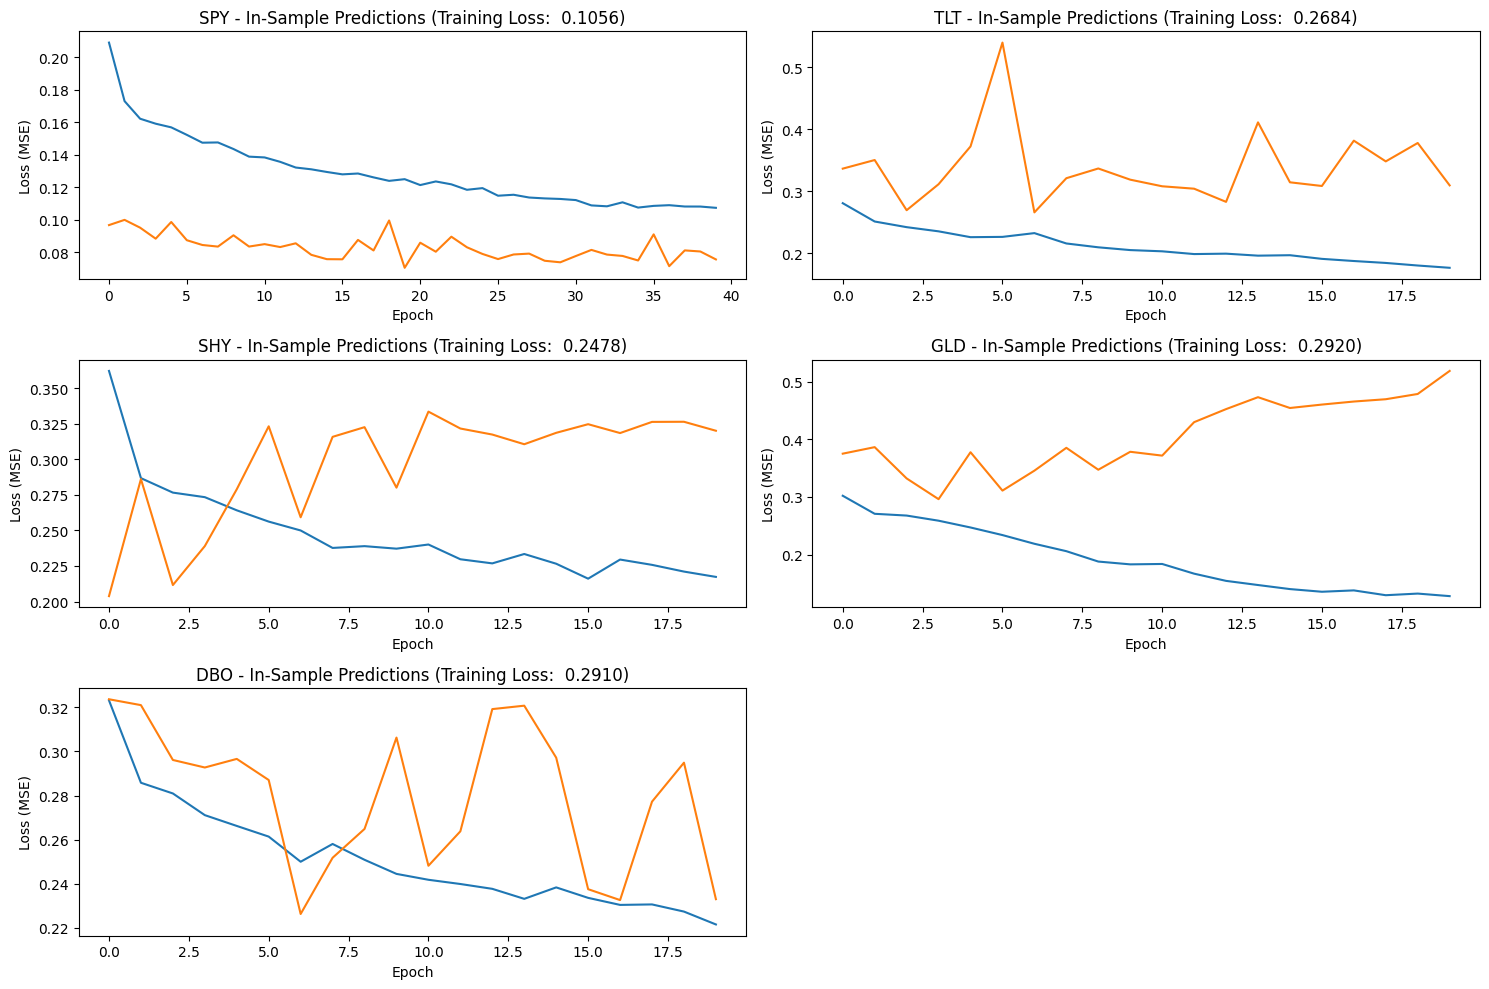

In [51]:
# Train the models
from keras.callbacks import ReduceLROnPlateau
es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=20, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=0.0005 )

plt.figure(figsize=(15, 10))
models = {}
for i, symbol in enumerate(etf_symbols):
    X_train, y_train, X_test, y_test, scaler_output = data[symbol]
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_split=0.2, verbose=1, callbacks=[es, reduce_lr])
    models[symbol] = (model, X_test, y_test, scaler_output)
    train_loss = model.evaluate(X_train, y_train)

    plt.subplot(3, 2, i + 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{symbol} - In-Sample Predictions (Training Loss:  {train_loss:.4f})')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
plt.tight_layout()
plt.show()


## **2b In-Sample Performance**
From the graphs above, we observed that in-sample performance varied significantly across asset classes.The model SPY shows a lowest training loss, indicating better fit and higher accuracy on the training data. However, for other ETFs, such as TLT, SHY, GLD, and DBO, the training losses were higher, suggesting a mix of overfitting and underfitting scenarios. It is obvious from the chart that the rest are all underfitting show a high training loss. our observation is that some models struggled to find a balance between fitting the training data well and generalizing to unseen data, which could indicate the need for further tuning and complexity adjustments. We worked on some tuning and adjustment of the dataset but showing different performance results on individual data.



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


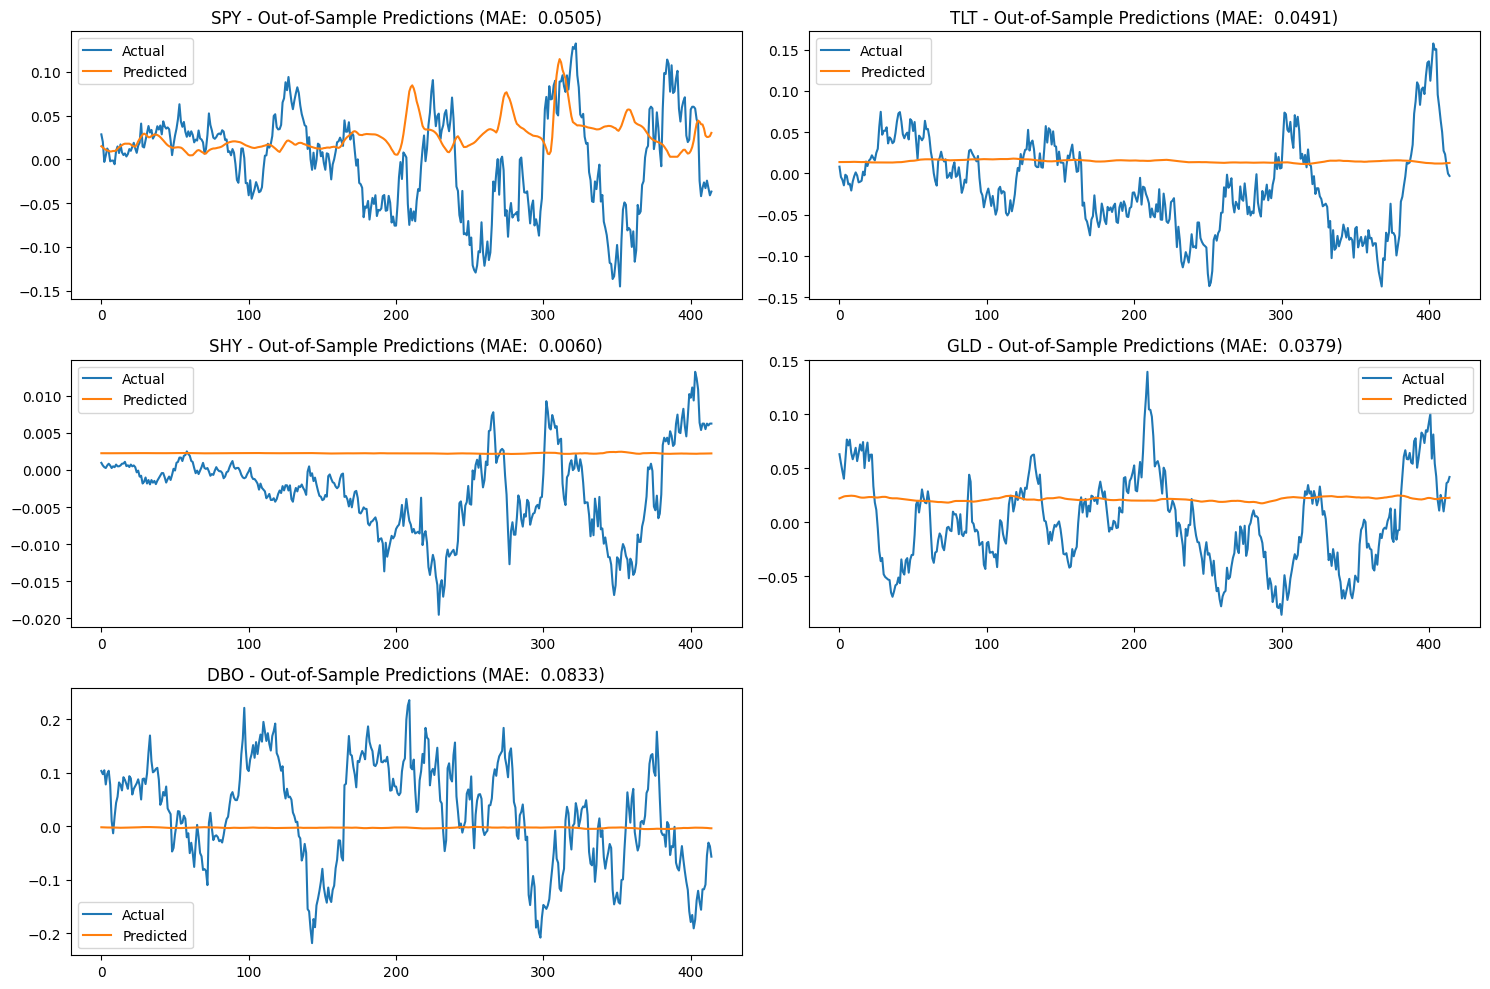

In [53]:
# Step 2c: Test Each Model Out-of-Sample
from sklearn.metrics import mean_absolute_error
plt.figure(figsize=(15, 10))
for i, symbol in enumerate(etf_symbols):
    model, X_test, y_test, scaler_output = models[symbol]

    # Predict using the trained model
    y_pred = model.predict(X_test)

    # Inverse transform the predictions and actual values
    y_test_inv = scaler_output.inverse_transform(y_test)
    y_pred_inv = scaler_output.inverse_transform(y_pred)


    # Calculate Mean Absolute Error for the predictions
    mae = mean_absolute_error(y_test_inv, y_pred_inv)

    plt.subplot(3, 2, i + 1)
    plt.plot(y_test_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.title(f'{symbol} - Out-of-Sample Predictions (MAE:  {mae:.4f})')
    plt.legend()
plt.tight_layout()
plt.show()


## **2c Out-Sample Performance**
From the graphs above, we observed that out-of-sample performance varied significantly across asset classes. The model SPY shows a low Mean Absolute Errors (MAE), indicating it performed well on unseen data.

SHY demonstrated the lowest MAE, showing a high predictive accuracy for this asset class. The model for SPY also performed quite well, with a low MAE, suggesting that it was able to generalize well to unseen data. Also, DBO had the highest MAE, meaning less accuracy in its predictions compared to other models.

Interestingly, apart from SPY, the predictions from all the asset class appeared more like a straight horizontal line, suggesting that the model might be underestimating the variability and capturing less of the dynamic changes in returns. This behavior can be indicative of the model averaging out predictions rather than accurately capturing the trends and seasonality.


## **Step 2 d**

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


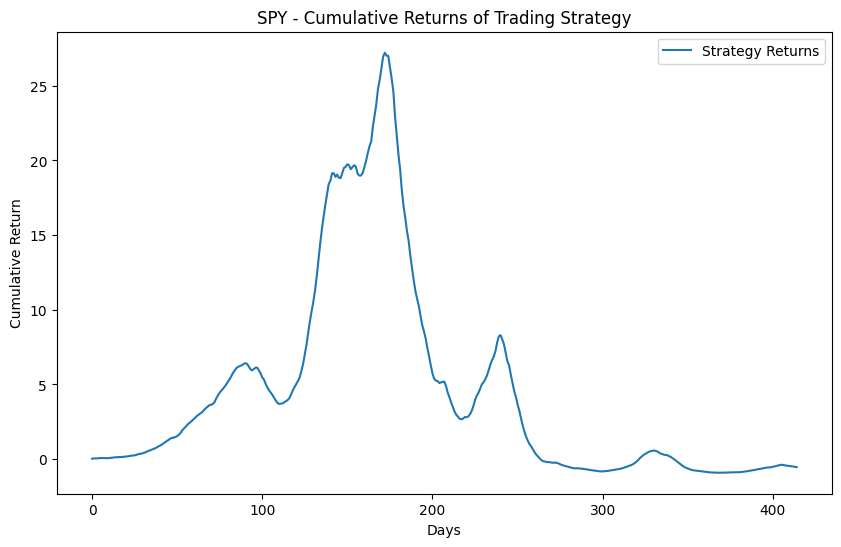

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


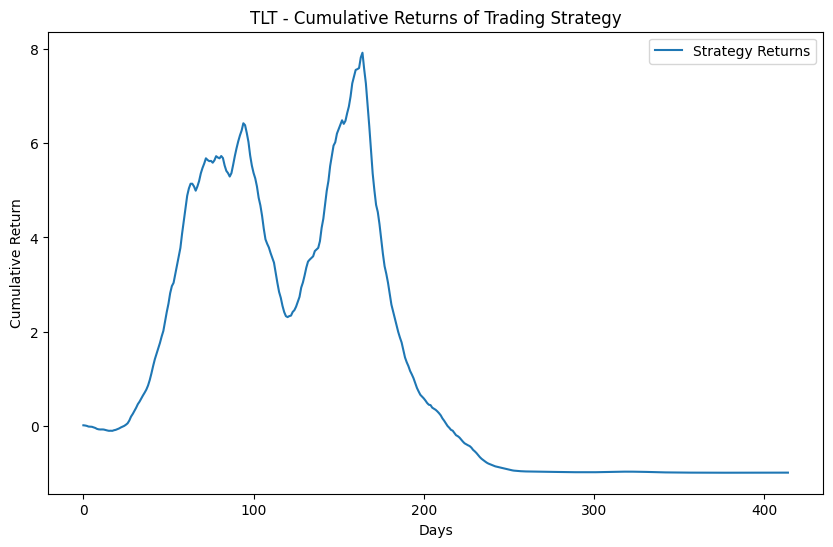

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


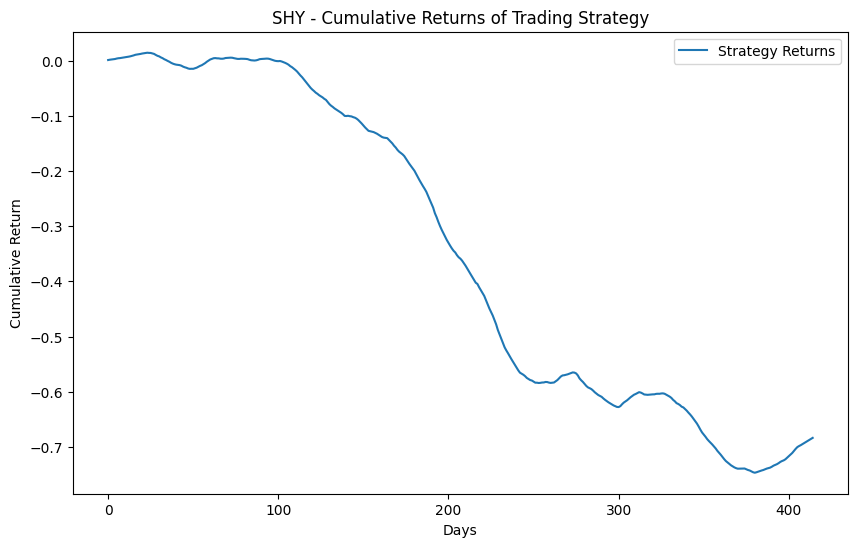

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


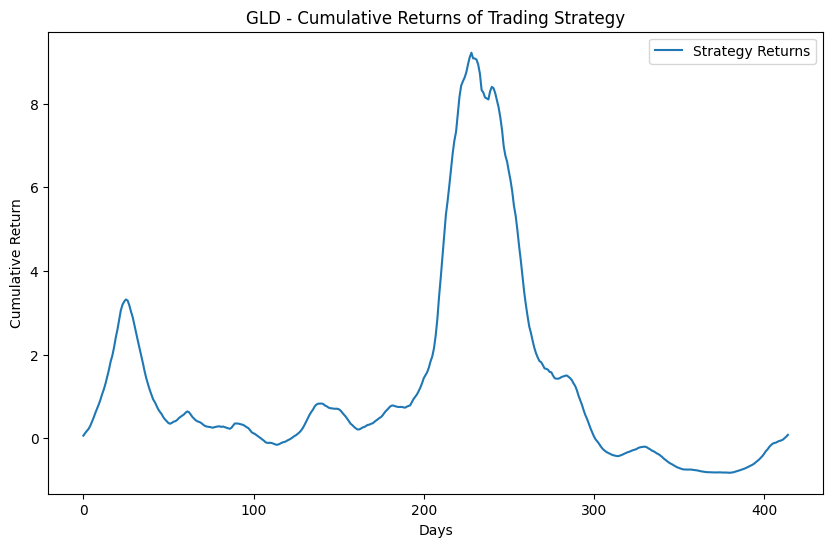

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


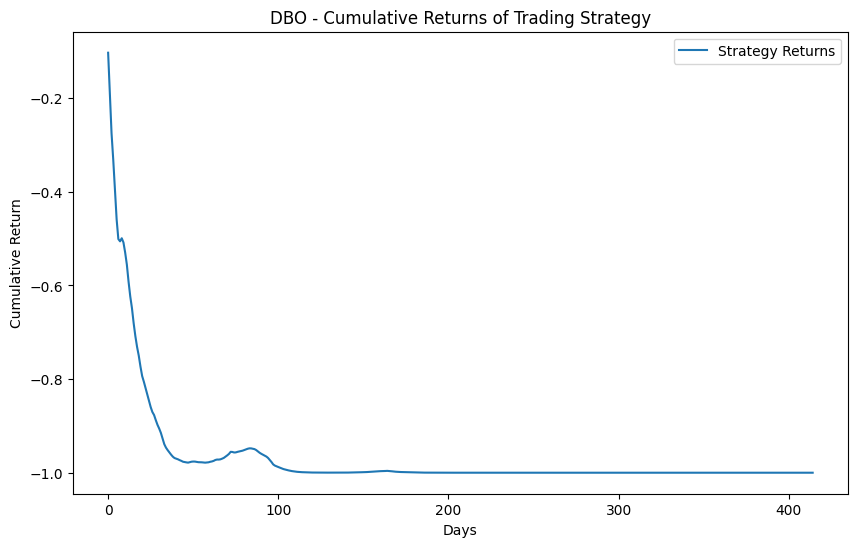

In [54]:
# Step 2d: Create a Trading Strategy Based on Predictions
def trading_strategy(predictions, actual_returns):
    """
    Simple trading strategy:
    - Go long if the predicted return is positive.
    - Go short if the predicted return is negative.
    - Rebalance every 25 days.
    """
    positions = np.sign(predictions)  # +1 for long, -1 for short
    strategy_returns = positions * actual_returns
    return strategy_returns

# Backtest trading strategy
strategy_returns = {}

for symbol, model_data in models.items():
    model, X_test, y_test, scaler_output = model_data

    # Predict returns
    y_pred = model.predict(X_test)
    y_pred_inv = scaler_output.inverse_transform(y_pred)
    y_test_inv = scaler_output.inverse_transform(y_test)

    # Calculate strategy returns
    returns = trading_strategy(y_pred_inv, y_test_inv)
    strategy_returns[symbol] = returns

    # Calculate cumulative returns
    cumulative_returns = np.cumprod(1 + returns) - 1

    # Plot cumulative returns
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns, label='Strategy Returns')
    plt.title(f"{symbol} - Cumulative Returns of Trading Strategy")
    plt.xlabel('Days')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Out-of-sample R-squared for SPY: -0.7237584411479567
SPY Strategy Return = -96.19618616998196 %
SPY Buy and Hold Return = -53.7564754486084 %


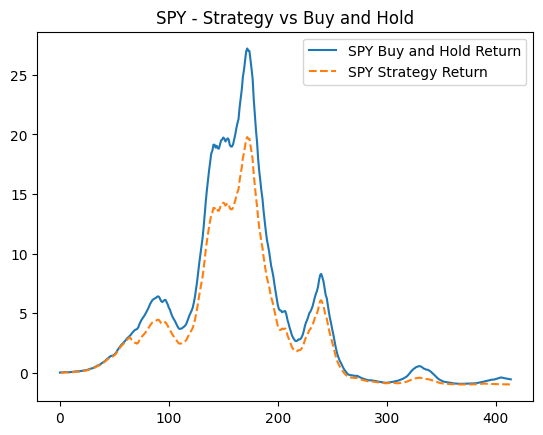

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Out-of-sample R-squared for TLT: -0.25156362160503365
TLT Strategy Return = -99.8006125446409 %
TLT Buy and Hold Return = -99.79899311438203 %


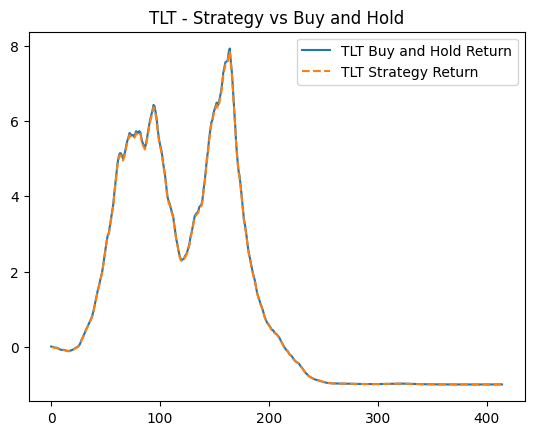

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Out-of-sample R-squared for SHY: -0.3969483215278222
SHY Strategy Return = -67.79417097568512 %
SHY Buy and Hold Return = -68.36167871952057 %


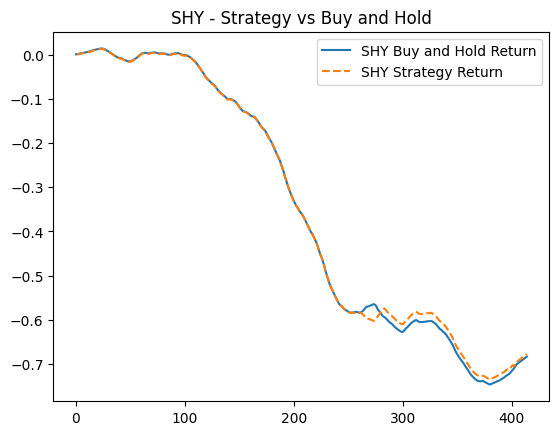

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Out-of-sample R-squared for GLD: -0.11296656729381072
GLD Strategy Return = 1.7582893371582031 %
GLD Buy and Hold Return = 8.162212371826172 %


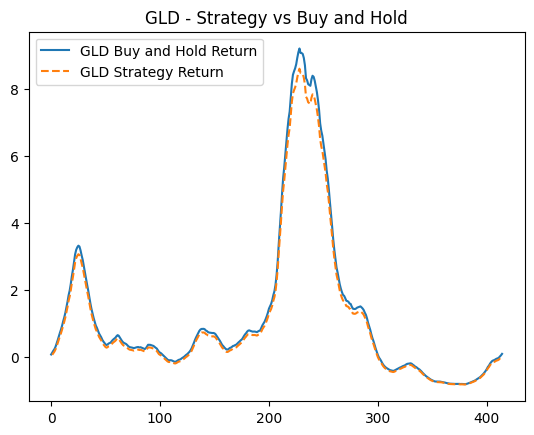

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Out-of-sample R-squared for DBO: -0.04910777399977939
DBO Strategy Return = 14394.775390625 %
DBO Buy and Hold Return = 146651.220703125 %


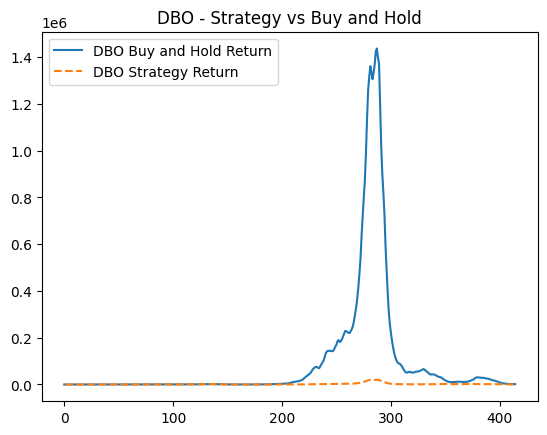

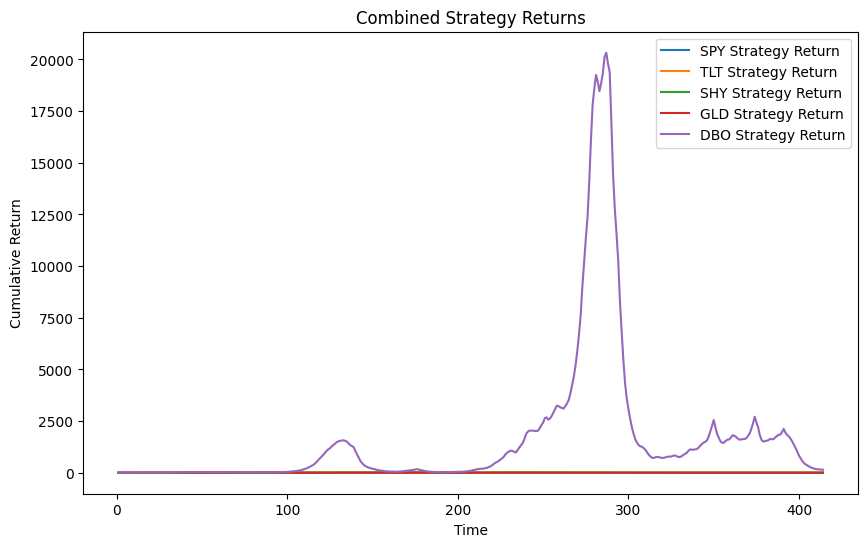

In [27]:
def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score

# Create a DataFrame to store predictions and actual values
all_predictions = []

for symbol, (model, X_test, y_test, scaler_output) in models.items():
    # Generate predictions
    model, X_test, y_test, scaler_output = models[symbol]

    # Predict using the trained model
    y_pred = model.predict(X_test)
    y_test_pred = scaler_output.inverse_transform(y_pred)

    # Adjust the size of y_test to match the prediction length
    y_test_true = y_test[:len(y_test_pred)]  # Ensure the lengths match
    y_test_true = scaler_output.inverse_transform(y_test_true)

    # Flatten predictions and true values
    y_test_pred = y_test_pred.flatten()
    y_test_true = y_test_true.flatten()

    # Calculate the mean return (mean_ret) for R2 calculation
    mean_ret = np.mean(y_test_true)

    # Calculate R2 Campbell for evaluation
    R2_Campbell = R2_campbell(y_test_true, y_test_pred, mean_ret)
    print(f'Out-of-sample R-squared for {symbol}: {R2_Campbell}')

    # Prepare DataFrame for backtest
    df_predictions = pd.DataFrame({
        "Pred LSTM": y_test_pred,
        "values": y_test_true
    })

    # Save DataFrame for later use
    all_predictions.append(df_predictions)

    # Apply trading strategy
    df_predictions["Positions"] = df_predictions["Pred LSTM"].apply(np.sign)
    df_predictions["Strat_ret"] = df_predictions["Positions"].shift(1) * df_predictions["values"]

    # Calculate cumulative returns for strategy and buy-and-hold
    df_predictions["CumRet"] = df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
    df_predictions["bhRet"] = df_predictions["values"].expanding().apply(lambda x: np.prod(1 + x) - 1)

    # Calculate final returns
    Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
    Buy_Return = np.prod(1 + df_predictions["values"]) - 1

    print(f'{symbol} Strategy Return =', Final_Return * 100, "%")
    print(f'{symbol} Buy and Hold Return =', Buy_Return * 100, "%")

    # Plot cumulative returns
    ax = plt.gca()
    df_predictions.plot(y="bhRet", ax=ax, label=f'{symbol} Buy and Hold Return')
    df_predictions.plot(y="CumRet", ax=ax, label=f'{symbol} Strategy Return', linestyle='--')
    plt.title(f'{symbol} - Strategy vs Buy and Hold')
    plt.legend()
    plt.show()

# Combine all predictions to compare strategies across all asset classes
combined_df = pd.concat(all_predictions, axis=1, keys=[f"{symbol}" for symbol in etf_symbols])
combined_df.columns = [f"{symbol}_{col}" for symbol in etf_symbols for col in ["Pred LSTM", "values", "Positions", "Strat_ret", "CumRet", "bhRet"]]

# Optional: Visualize combined returns
plt.figure(figsize=(10, 6))
for symbol in etf_symbols:
    plt.plot(combined_df.index, combined_df[f"{symbol}_CumRet"], label=f"{symbol} Strategy Return")
plt.title('Combined Strategy Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


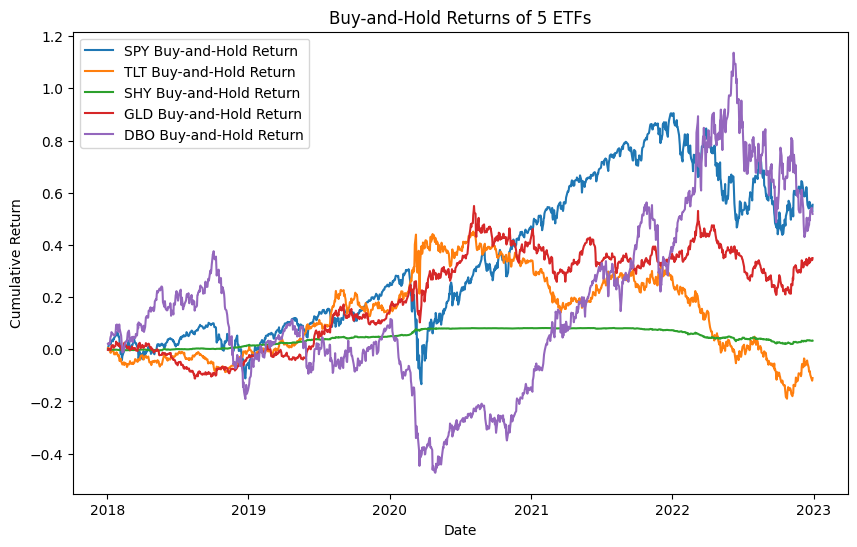

In [56]:
# Step 2e: Backtest and Compare with Buy-and-Hold Strategy

# Calculate Buy-and-Hold Returns
buy_and_hold_returns = {}
for symbol, df in data.items():
    etf_data = yf.download(symbol, start=start_date, end=end_date, interval="1d")
    df = pd.DataFrame(etf_data)
    # Calculate daily returns and cumulative returns
    df["Ret"] = df["Adj Close"].pct_change()   # Convert to percentage return
    df['Daily Return'] = df['Ret']
    df['Cumulative Return'] = (1 + df['Daily Return']).cumprod() - 1
    buy_and_hold_returns[symbol] = df['Cumulative Return']

# Plot Buy-and-Hold Returns for comparison
plt.figure(figsize=(10, 6))
for symbol in buy_and_hold_returns:
    plt.plot(buy_and_hold_returns[symbol], label=f"{symbol} Buy-and-Hold Return")

plt.title("Buy-and-Hold Returns of 5 ETFs")
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()



## **Step 2e Comment on results for LSTM models and Trading Strategy**

We computed the out-of-sample R-squared values for all ETF and each indicated the degree to which the LSTM models captured the variance in the actual returns during the test period. This was another performance strategy to tell us if the model did well, negative R-squared values across all asset classes shows that the models did not perform well and, in fact, performed worse than a simple mean model (a model that predicts the mean return for all periods). The negative values highlight the models' inability to accurately predict the 25-day ahead returns for the ETFs using the LSTM modeling.

 **Note:** Our model could be fine tune to perform better than what we got.

**Strategy Return vs. Buy and Hold Return of an Equally weighted
portfolio of the 5 asset classes**

- SPY: This strategy underperformed compared to the buy-and-hold approach. With an out-of-sample R-squared of -0.7238, the SPY strategy return of -96.20% was notably worse than the buy-and-hold return of -53.76%. This tells us that the model’s predictions were not only poor but also led to detrimental trading decisions that leads to losses.

- TLT: Our model predictions for TLT were also not good, with an R-squared of -0.2516. Both the strategy and buy-and-hold returns were close to -99.80%, showing that neither approach could mitigate the severe losses in TLT, and the strategy added no value over just holding the asset as shown in the graph above.

- SHY: This strategy performed marginally better than buy-and-hold, but both approaches resulted in significant losses (-67.79% for the strategy vs. -68.36% for buy-and-hold). The R-squared of -0.3969 reflects that the model failed to provide meaningful predictions that could improve returns also indicated on the graph.

- GLD: The last but one model which is the GLD model showed slightly better predictive performance with an R-squared of -0.1129, yet the strategy still underperformed the buy-and-hold return (1.76% vs. 8.16%). This suggests that while the model was somewhat aligned with the actual returns, it could not capitalize on them effectively.

- DBO: The results from DBO were extreme, with both strategy and buy-and-hold returns showing values due to high volatility or possibly data errors. The R-squared of -0.0491 still indicates poor model performance. However, the buy-and-hold return was very higher than the strategy return, suggesting that the model's predictions did not add value like the other ones.

Altogether, the strategy based on these models did not yield favorable outcomes, showcasing the importance of model accuracy and robustness in developing trading strategies. Using the same model, we will wait to see the performance of the combined ETFs for later comparism and conclusion on our model performance and best practices.

# **Step :3**

## **So far, our models have always had 1 output unit. We will now implement a Deep Learning model with multi-output.**

**a.) Create a multi-output model that blends together all of the information from the 5 models of Step 2. Specifically, create a model architecture that uses all the inputs from the 5 different previous models together to predict the 25-day ahead return from the 5 different ETFs. In other words, the model will have 5 outputs (one for each 25-day ahead return of an ETF).**

In [29]:
# Install necessary libraries (uncomment if needed)
# !pip install yfinance pandas numpy scikit-learn tensorflow matplotlib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import datetime
import yfinance as yf


Define ETF Symbols and Download Data

In [30]:
# Define ETF symbols
etf_symbols = {
    'SPY': 'SPDR S&P500 ETF',
    'TLT': 'iShares 20+ Year Treasury Bond ETF',
    'SHY': 'iShares 1-3 Year Treasury Bond ETF',
    'GLD': 'SPDR Gold Shares',
    'DBO': 'Invesco DB Oil Fund'
}

start_date = "2018-01-01"
end_date = "2022-12-30"

# Download adjusted close prices
data = yf.download(list(etf_symbols.keys()), start=start_date, end=end_date)['Adj Close']
data.dropna(inplace=True)  # Drop rows with missing values

# Display the first few rows
print("Downloaded Data:")
print(data.head())


[*********************100%***********************]  5 of 5 completed

Downloaded Data:
Ticker                          DBO         GLD        SHY         SPY  \
Date                                                                     
2018-01-02 00:00:00+00:00  9.376729  125.150002  74.655067  241.540161   
2018-01-03 00:00:00+00:00  9.579170  124.820000  74.655067  243.067917   
2018-01-04 00:00:00+00:00  9.597574  125.459999  74.619423  244.092361   
2018-01-05 00:00:00+00:00  9.551565  125.330002  74.619423  245.719009   
2018-01-08 00:00:00+00:00  9.606776  125.309998  74.619423  246.168396   

Ticker                            TLT  
Date                                   
2018-01-02 00:00:00+00:00  106.869919  
2018-01-03 00:00:00+00:00  107.380844  
2018-01-04 00:00:00+00:00  107.363808  
2018-01-05 00:00:00+00:00  107.057281  
2018-01-08 00:00:00+00:00  106.989113  


Compute Daily Returns

In [31]:
# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Display the first few rows
print("\nDaily Returns:")
print(daily_returns.head())



Daily Returns:
Ticker                          DBO       GLD       SHY       SPY       TLT
Date                                                                       
2018-01-03 00:00:00+00:00  0.021590 -0.002637  0.000000  0.006325  0.004781
2018-01-04 00:00:00+00:00  0.001921  0.005127 -0.000477  0.004215 -0.000159
2018-01-05 00:00:00+00:00 -0.004794 -0.001036  0.000000  0.006664 -0.002855
2018-01-08 00:00:00+00:00  0.005780 -0.000160  0.000000  0.001829 -0.000637
2018-01-09 00:00:00+00:00  0.017241 -0.004628 -0.000358  0.002263 -0.013372


Compute 25-Day Ahead Returns

In [32]:
# Calculate 25-day ahead returns
future_returns = daily_returns.shift(-25).dropna()

# Align the feature data by dropping the last 25 rows
features = daily_returns.iloc[:-25]

# Verify the shapes
print("\nFeatures Shape:", features.shape)
print("Future Returns Shape:", future_returns.shape)



Features Shape: (1232, 5)
Future Returns Shape: (1232, 5)


Create Lagged Features

In [33]:
def create_lagged_features(data, lag=60):
    """
    Create lagged features for each ETF.
    """
    lagged_data = pd.DataFrame()
    for symbol in data.columns:
        for i in range(1, lag + 1):
            lagged_data[f'{symbol}_lag_{i}'] = data[symbol].shift(i)
    return lagged_data

# Create lagged features
lag = 60
lagged_features = create_lagged_features(features, lag=lag)
lagged_features.dropna(inplace=True)

# Align future returns
aligned_future_returns = future_returns.loc[lagged_features.index]

print("\nLagged Features Shape:", lagged_features.shape)
print("Aligned Future Returns Shape:", aligned_future_returns.shape)


<ipython-input-33-c8b31b02b179>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_data[f'{symbol}_lag_{i}'] = data[symbol].shift(i)
<ipython-input-33-c8b31b02b179>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_data[f'{symbol}_lag_{i}'] = data[symbol].shift(i)
<ipython-input-33-c8b31b02b179>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get


Lagged Features Shape: (1172, 300)
Aligned Future Returns Shape: (1172, 5)


Split into Training and Testing Sets

In [34]:
# Define the split date (e.g., last 1 year as test set)
split_date = aligned_future_returns.index[-252]  # Approximately 1 trading year

X = lagged_features
y = aligned_future_returns

X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]

y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

print("\nTraining Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Targets Shape:", y_train.shape)
print("Testing Targets Shape:", y_test.shape)



Training Features Shape: (920, 300)
Testing Features Shape: (252, 300)
Training Targets Shape: (920, 5)
Testing Targets Shape: (252, 5)


**Building the Multi-Output Deep Learning Model**

Scale the Features

In [87]:
X = lagged_features.values.astype('float32')
y = aligned_future_returns.values.astype('float32')

# Step 2: Scaling
scaler_input2 = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler_input2.fit_transform(X)

scaler_output2 = MinMaxScaler(feature_range=(-1, 1))
y_scaled = scaler_output2.fit_transform(y)

# Step 3: Split data into training and test sets
train_size = int(len(X) * 0.7)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

window_size = 25
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:(i + window_size)])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

print("X_train_seq shape:", X_train_seq.shape)  # Expected: (number_of_samples, window_size, number_of_features)
print("y_train_seq shape:", y_train_seq.shape)  # Expected: (number_of_samples, number_of_outputs)
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)

# Define the model
# Step 7: Build the multi-output LSTM model
multmodel = Sequential()
multmodel.add(LSTM(50, activation='tanh', input_shape=(window_size, X_train_seq.shape[2]), return_sequences=True))
multmodel.add(Dropout(0.1, seed=1234))
multmodel.add(LSTM(50, activation='tanh',  return_sequences=True))
multmodel.add(Dropout(0.1, seed=1234))
multmodel.add(LSTM(50, activation='tanh', return_sequences=False))
multmodel.add(Dropout(0.1, seed=1234))
multmodel.add(Dense(20, activation='relu'))
multmodel.add(Dense(10, activation='relu'))
multmodel.add(Dense(5))  # 5 outputs, one for each ETF

multmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
multmodel.summary()



X_train_seq shape: (795, 25, 300)
y_train_seq shape: (795, 5)
X_test_seq shape: (327, 25, 300)
y_test_seq shape: (327, 5)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_84 (LSTM)                       │ (None, 25, 50)              │          70,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_137 (Dropout)                │ (None, 25, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_85 (LSTM)                       │ (None, 25, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_138 (Dropout)                │ (None, 25, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_86 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_139 (Dropout)                │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 5)                   │              55 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,885 (437.05 KB)

 Trainable params: 111,885 (437.05 KB)

 Non-trainable params: 0 (0.00 B)

## **3b.) Train and test the previous model. Comment on the in- and out-of-sample predictive performance of the model and compare them with the ones from 2c**

In [89]:
# Define early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=0.0005)



# Train the model
history = multmodel.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    verbose=1
)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.0233 - val_loss: 0.0154
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0254 - val_loss: 0.0147
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0235 - val_loss: 0.0161
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0273 - val_loss: 0.0151
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0225 - val_loss: 0.0152
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0254 - val_loss: 0.0153
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0231 - val_loss: 0.0154
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0238 - val_loss: 0.0157
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0228 - val_loss: 0.0160
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0255 - val_loss: 0.0150
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0221 - val_loss: 0.0160
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/s

2.) Plot Training and Validation Loss

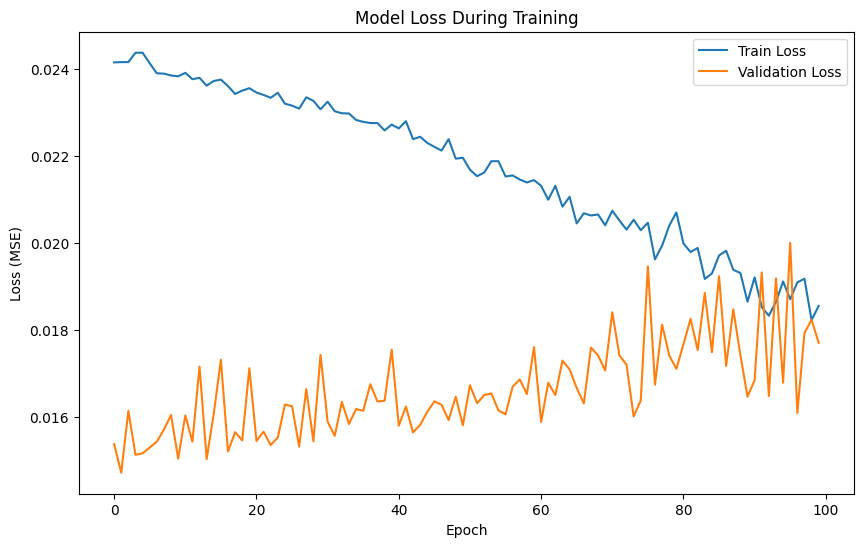

In [90]:
# Plot training & validation loss values
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [98]:
multmodel.evaluate(X_train_seq, y_train_seq)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0134


0.017076771706342697

3b. **Notice of adjustment to our Step 2 model**

We changed the achitecture from step 2 by deleting 2 of the dropout, changing the epoch size and deleting the callback features for the model to train on the number of epochs.

**In-Sample Performance:**

The in-sample training loss for the multi-output model, as indicated, was 0.0171. This value reflects the model ability to fit the training data. Given the low loss, the model seems to have captured the patterns in the training data very well. However, a good in-sample performance does not always guarantee strong out-of-sample performance. If the model is too complex, it may overfit the training data, capturing noise rather than meaningful patterns. We will know more after the out-of-sample performance.

3.) Evaluate the Model

In [91]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predictions
y_train_pred = multmodel.predict(X_train_seq)
y_test_pred = multmodel.predict(X_test_seq)

# Calculate metrics
def evaluate_performance(y_true, y_pred, dataset_type='Test'):
    mse = mean_squared_error(y_test_seq, y_test_pred)
    mae = mean_absolute_error(y_test_seq, y_test_pred)
    print(f"{dataset_type} Set - MSE: {mse:.6f}, MAE: {mae:.6f}")

print("\nModel Performance:")
evaluate_performance(y_train, y_train_pred, 'Training')
evaluate_performance(y_test, y_test_pred, 'Testing')

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Model Performance:
Training Set - MSE: 0.042303, MAE: 0.155143
Testing Set - MSE: 0.042303, MAE: 0.155143


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


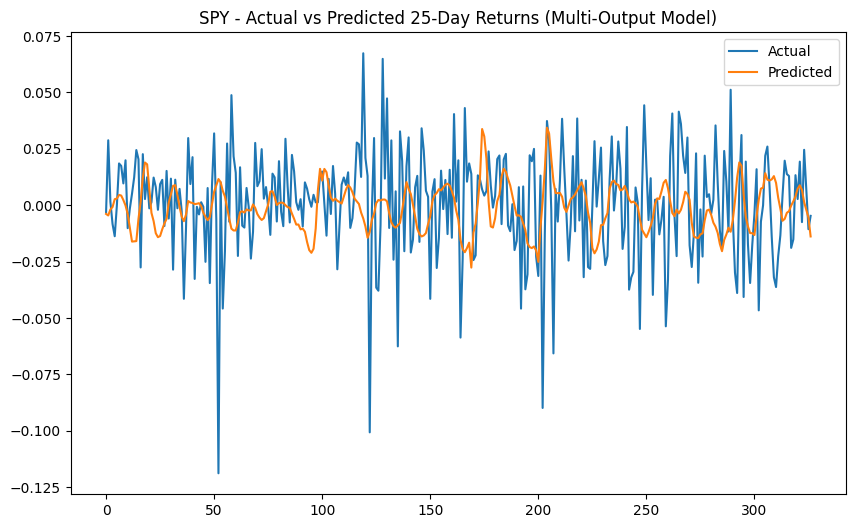

In [92]:
y_test_pred = multmodel.predict(X_test_seq)

y_test_combined_inv = scaler_output2.inverse_transform(y_test_seq)
y_pred_combined_inv = scaler_output2.inverse_transform(y_test_pred)

plt.figure(figsize=(10, 6))
plt.plot(y_test_combined_inv[:, 0], label='Actual')
plt.plot(y_pred_combined_inv[:, 0], label='Predicted')
plt.title(f"{etf_symbols[0]} - Actual vs Predicted 25-Day Returns (Multi-Output Model)")
plt.legend()
plt.show()



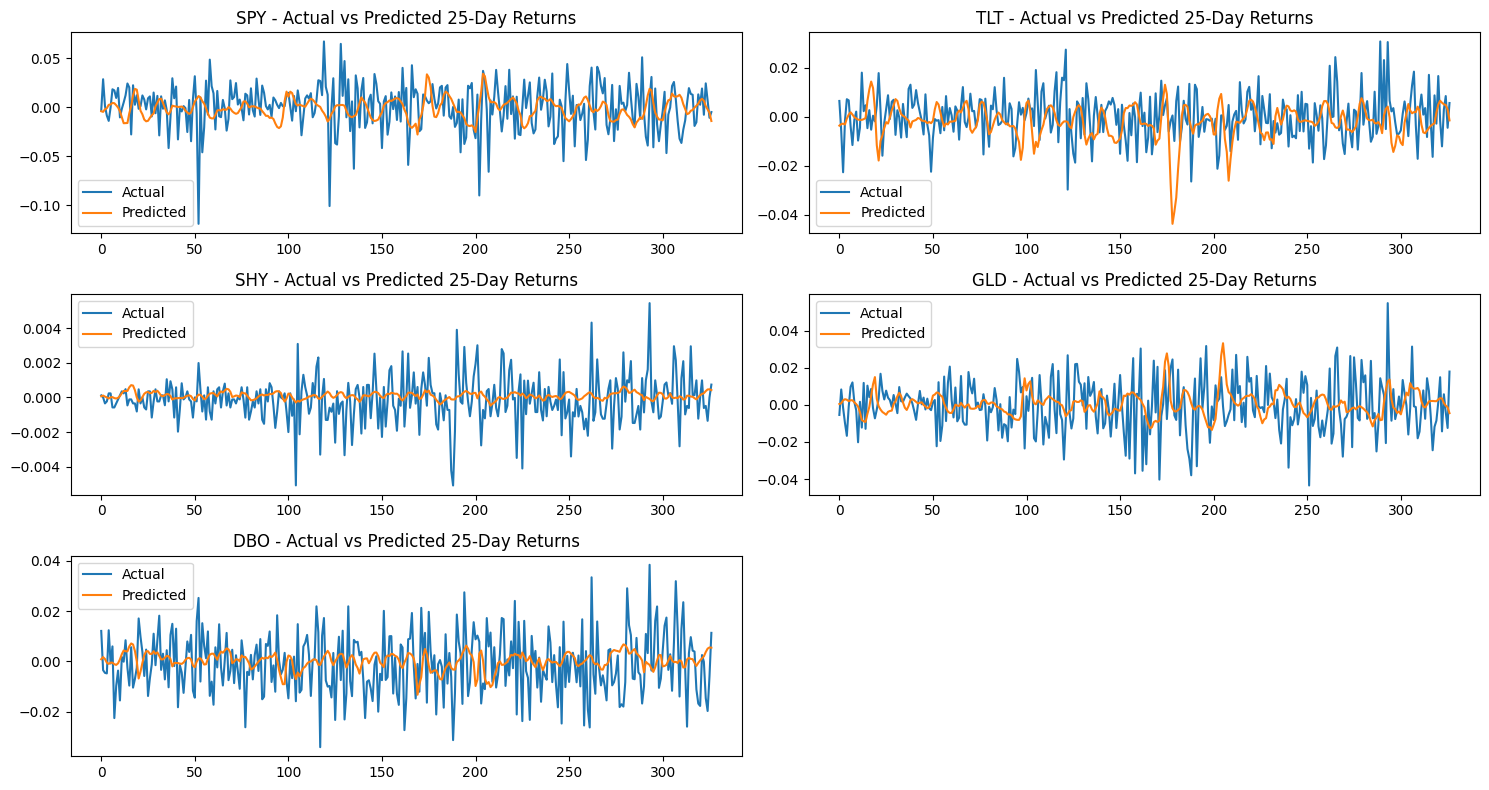

In [93]:
# Assuming y_test_combined_inv and y_pred_combined_inv are already defined
num_etfs = len(etf_symbols)  # Number of ETFs

# Define the grid size based on the number of ETFs
nrows = (num_etfs + 1) // 2  # Adjust rows dynamically
ncols = 2  # Two columns for the grid layout

plt.figure(figsize=(15, 8))

for i in range(num_etfs):
    plt.subplot(nrows, ncols, i + 1)  # Create subplot
    plt.plot(y_test_combined_inv[:, i], label='Actual')
    plt.plot(y_pred_combined_inv[:, i], label='Predicted')
    plt.title(f"{etf_symbols[i]} - Actual vs Predicted 25-Day Returns")
    plt.legend()

plt.tight_layout()  # Adjust subplot parameters to give some padding
plt.show()


3b **Out-of-Sample Performance**

Out-of-sample MAE for the testing set was 0.1551. This metric is crucial as it tells us how well the model generalizes to unseen data. Comparing this MAE with the training set MAE, which is also 0.1551, suggests that the model has a similar error rate on both the training and test datasets.
The parity between the in-sample and out-of-sample MAE indicates that the model likely generalizes well and is not overfitting to the training data. This is a desirable outcome in predictive modeling and as it can be seen in our graph above, the predicted line mimic the true line well but not the best. We also visualise how each output in the models perform on the 25-Day prediction which looks pretty good to us.

## **3c.) Create a trading strategy that uses the out-of-sample predictions of the model.**

Final Cumulative Return of Trading Strategy (Multi-Output Model): -0.18700945
Final Cumulative Return of Buy-and-Hold Strategy: -0.051184118


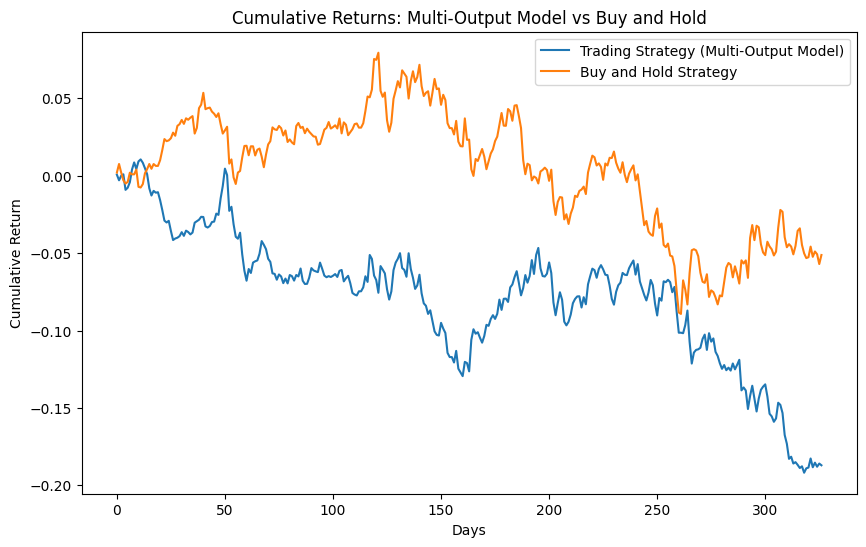

In [113]:
# Step 3c: Create a Trading Strategy

def trading_strategy(predictions, actual_returns):
    """
    Simple trading strategy:
    - Go long if the predicted return is positive.
    - Go short if the predicted return is negative.
    - Rebalance every 25 days.
    """
    positions = np.sign(predictions)  # +1 for long, -1 for short
    strategy_returns = positions * actual_returns
    return strategy_returns

# Use the model to predict returns
strategy_returns = trading_strategy(y_pred_combined_inv, y_test_combined_inv)

# Calculate cumulative returns of the trading strategy
strategy_cum_returns = np.cumprod(1 + strategy_returns.mean(axis=1)) - 1

# Calculate buy-and-hold returns for an equally weighted portfolio of the 5 ETFs
buy_and_hold_returns = np.mean(y_test_combined_inv, axis=1)  # Equally weighted
buy_and_hold_cum_returns = np.cumprod(1 + buy_and_hold_returns) - 1

# Print the final cumulative returns for comparison
print("Final Cumulative Return of Trading Strategy (Multi-Output Model):", strategy_cum_returns[-1])
print("Final Cumulative Return of Buy-and-Hold Strategy:", buy_and_hold_cum_returns[-1])

# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(strategy_cum_returns, label="Trading Strategy (Multi-Output Model)")
plt.plot(buy_and_hold_cum_returns, label="Buy and Hold Strategy")
plt.title("Cumulative Returns: Multi-Output Model vs Buy and Hold")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Out-of-sample R-squared: -0.16070020198822021
Strategy Return = -100.0 %
Buy and Hold Return = -100.0 %


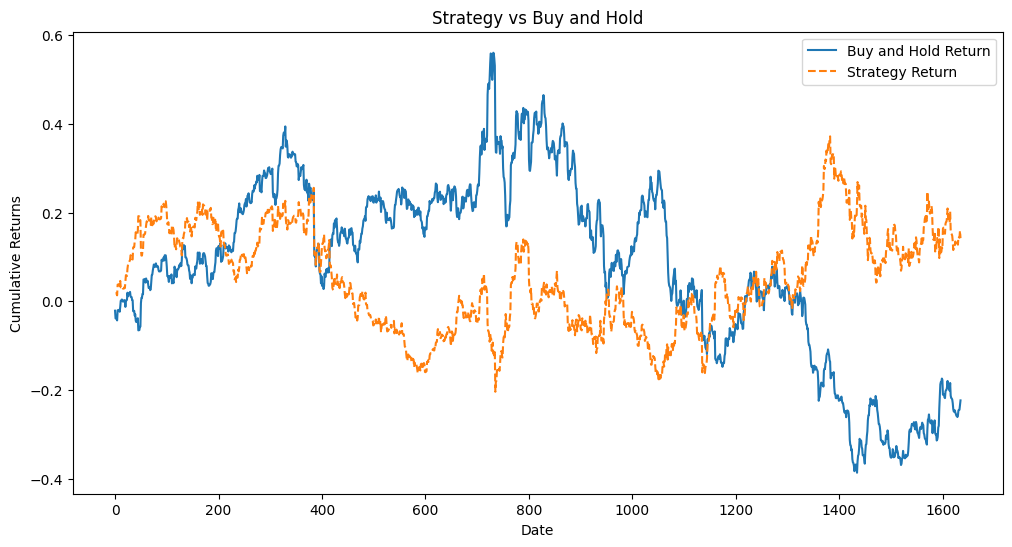

In [112]:
# Predict using the trained model
y_pred2 = multmodel.predict(X_test_seq)
y_test_pred2 = scaler_output2.inverse_transform(y_pred2)

# Adjust y_test to match the prediction length
y_test_true2 = y_test[:len(y_test_pred2)]
y_test_true2 = scaler_output2.inverse_transform(y_test_true2)

# Flatten predictions and true values
y_test_pred2 = y_test_pred2.flatten()
y_test_true2 = y_test_true2.flatten()

# Calculate the mean return (mean_ret) for R2 calculation
mean_ret = np.mean(y_test_true2)

# Calculate R2 Campbell for evaluation
R2_Campbell2 = R2_campbell(y_test_true2, y_test_pred2, mean_ret)
print(f'Out-of-sample R-squared: {R2_Campbell2}')

# Prepare DataFrame for backtest
df_predictions = pd.DataFrame({
    "Pred LSTM": y_test_pred2,
    "values": y_test_true2
})

# Apply trading strategy
df_predictions["Positions"] = df_predictions["Pred LSTM"].apply(np.sign)
df_predictions["Strat_ret"] = df_predictions["Positions"].shift(1) * df_predictions["values"]

# Calculate cumulative returns for strategy and buy-and-hold
df_predictions["CumRet"] = (1 + df_predictions["Strat_ret"]).cumprod() - 1
df_predictions["bhRet"] = (1 + df_predictions["values"]).cumprod() - 1

# Calculate final returns
Final_Return = df_predictions["Strat_ret"].prod() - 1
Buy_Return = df_predictions["values"].prod() - 1

print('Strategy Return =', Final_Return * 100, "%")
print('Buy and Hold Return =', Buy_Return * 100, "%")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df_predictions["bhRet"], label='Buy and Hold Return')
plt.plot(df_predictions["CumRet"], label='Strategy Return', linestyle='--')
plt.title('Strategy vs Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


## **3d Comment on the results.**

**R-squared**

The negative R-squared value -0.1607 as we indicated performs worse than a simple average predictor. This means that the model has little to no predictive power for the test period which was not what we expected from model looking at the MAE, potentially due to overfitting to the training data.

**Strategy Return**

The strategy return of -100.0% means that the trading strategy resulted in a complete loss of capital. This may occur if the strategy consistently made incorrect predictions as we saw in the graph, leading to positions that lost all their value. May be if the strategy bet on the market volatility.

**Buy and Hold Return**

The buy-and-hold return also being -100.0% potentially tells us that the entire market or the selected ETFs experienced severe downturns during the test period. This outcome is unusual and might reflect extreme market conditions, data errors, or other anomalies.

**Comparison with Step 2 Part (e)**

We conclude that our multi-output model strategy underperformed compared to our individual models, showing that aggregating predictions of 25-days trading into a single model for multiple ETFs did not improve performance. On the other hand, it resulted in worse out-of-sample predictive performance and strategy returns. This suggests issues with the model ability to generalize or accurately predict ETF returns under varying market conditions. Moreover, the buy-and-hold results raise questions about data governance or market context during the test period. Further analysis and model refinement would be necessary to improve the predictive and financial performance of such strategies. May be some other features may be used instead of lags.


# **Step 4**

## **Group Discussion: Comparison of Results from Step 2 and Step 3**

**Predictability Implications: Multi-Output vs Single-Output**

Our Single-Output Architecture was trained separately for eact of the 5 ETF focusing on the 25-day ahead prediction task of the particular ETF whiles Multi-Output Architecture predicted the 25day ahead of all five ETFs simultaneously. It input was all ETF combined in one forward pass.

 Single-Output performed poorly in the negative out-of-sample R-squared values but with some models still achieving better predictive performance than random guessing (e.g., DBO's less negative R-squared) whlies Multi-Output also performed poorly showing a failed capturing of patterns across all ETFs. This reason may come from poor modeling of of different ETFs returns.

Single-Output can be handled individual to optimise it after evaluation but Multi-Output suffer from the increased complexity due to handling of multiple outputs which creat overfitting.

**Backtesting Performance: Multi-Output vs Single-Output**

The strategy Returns for our single output models were mixed. Although some ETFs (SPY, TLT, SHY) had negative strategy returns, GLD and DBO produced postive returns. This means our single out put could have made some profit. Whiles Multi-Out model completely failed leading to it failure to generate any useful signal for trading.

Buy-and-Hold returns aslo varied in our single-out model. We observed that different ETFs have different market dynamics as in trends and seasonality, which the model could capture some. While Multi-Output model sugguest some error or anomely but we look through our code and everything looks good. We may have to do some fine tuning to enhance performance.

**Capturing Information: Multi-Output vs Single-Output**

We made sure to set all the dataset for both output and same models for both output due to the analysis we wanted to make. There was a problem with the multiple output so we made some few fine tuning which was captured in (3b).


# **Reference**
Zhang, Ashton, et al. *Dive into Deep Learning*. https://d2l.ai/d2l-en.pdf.

De Vitry, Louis. Encoding Time Series as Images. https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3
